# 1. Libraries and Settings

In [ ]:
import os
from itertools import chain
import random
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image, ImageEnhance, ImageOps

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

In [ ]:
# helper method to diaplay an image
def show(img, figsize=(8, 32), title=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.show()

# 2. Data Collection
- The group is consist of 5 members. Thus the dataset has 5 labels
- Each member is required to write each digit in `0-9`,`a-z`,`A-Z` for 4 times in one page.
- Therefore, there are `62 * 4 = 248` samples per label, 1240 example digits in total.
- The test set is set to 20.16% so that there are 198 training examples per label and 50 test examples per label

In [ ]:
!mkdir digits_large
# download image dataset
!cd digits_large && wget -qnc https://raw.githubusercontent.com/yyleaves/handwritten-mnist/main/digits_large/chooiyeng.png
!cd digits_large && wget -qnc https://raw.githubusercontent.com/yyleaves/handwritten-mnist/main/digits_large/jaraelyn.png
!cd digits_large && wget -qnc https://raw.githubusercontent.com/yyleaves/handwritten-mnist/main/digits_large/patricia.png
!cd digits_large && wget -qnc https://raw.githubusercontent.com/yyleaves/handwritten-mnist/main/digits_large/weisze.png
!cd digits_large && wget -qnc https://raw.githubusercontent.com/yyleaves/handwritten-mnist/main/digits_large/yeyang.png

In [ ]:
input_folder = './digits_large/'
members = os.listdir(input_folder)
!mkdir datasets

num_classes = len(members)

## 2.1 Display Original Written Digits

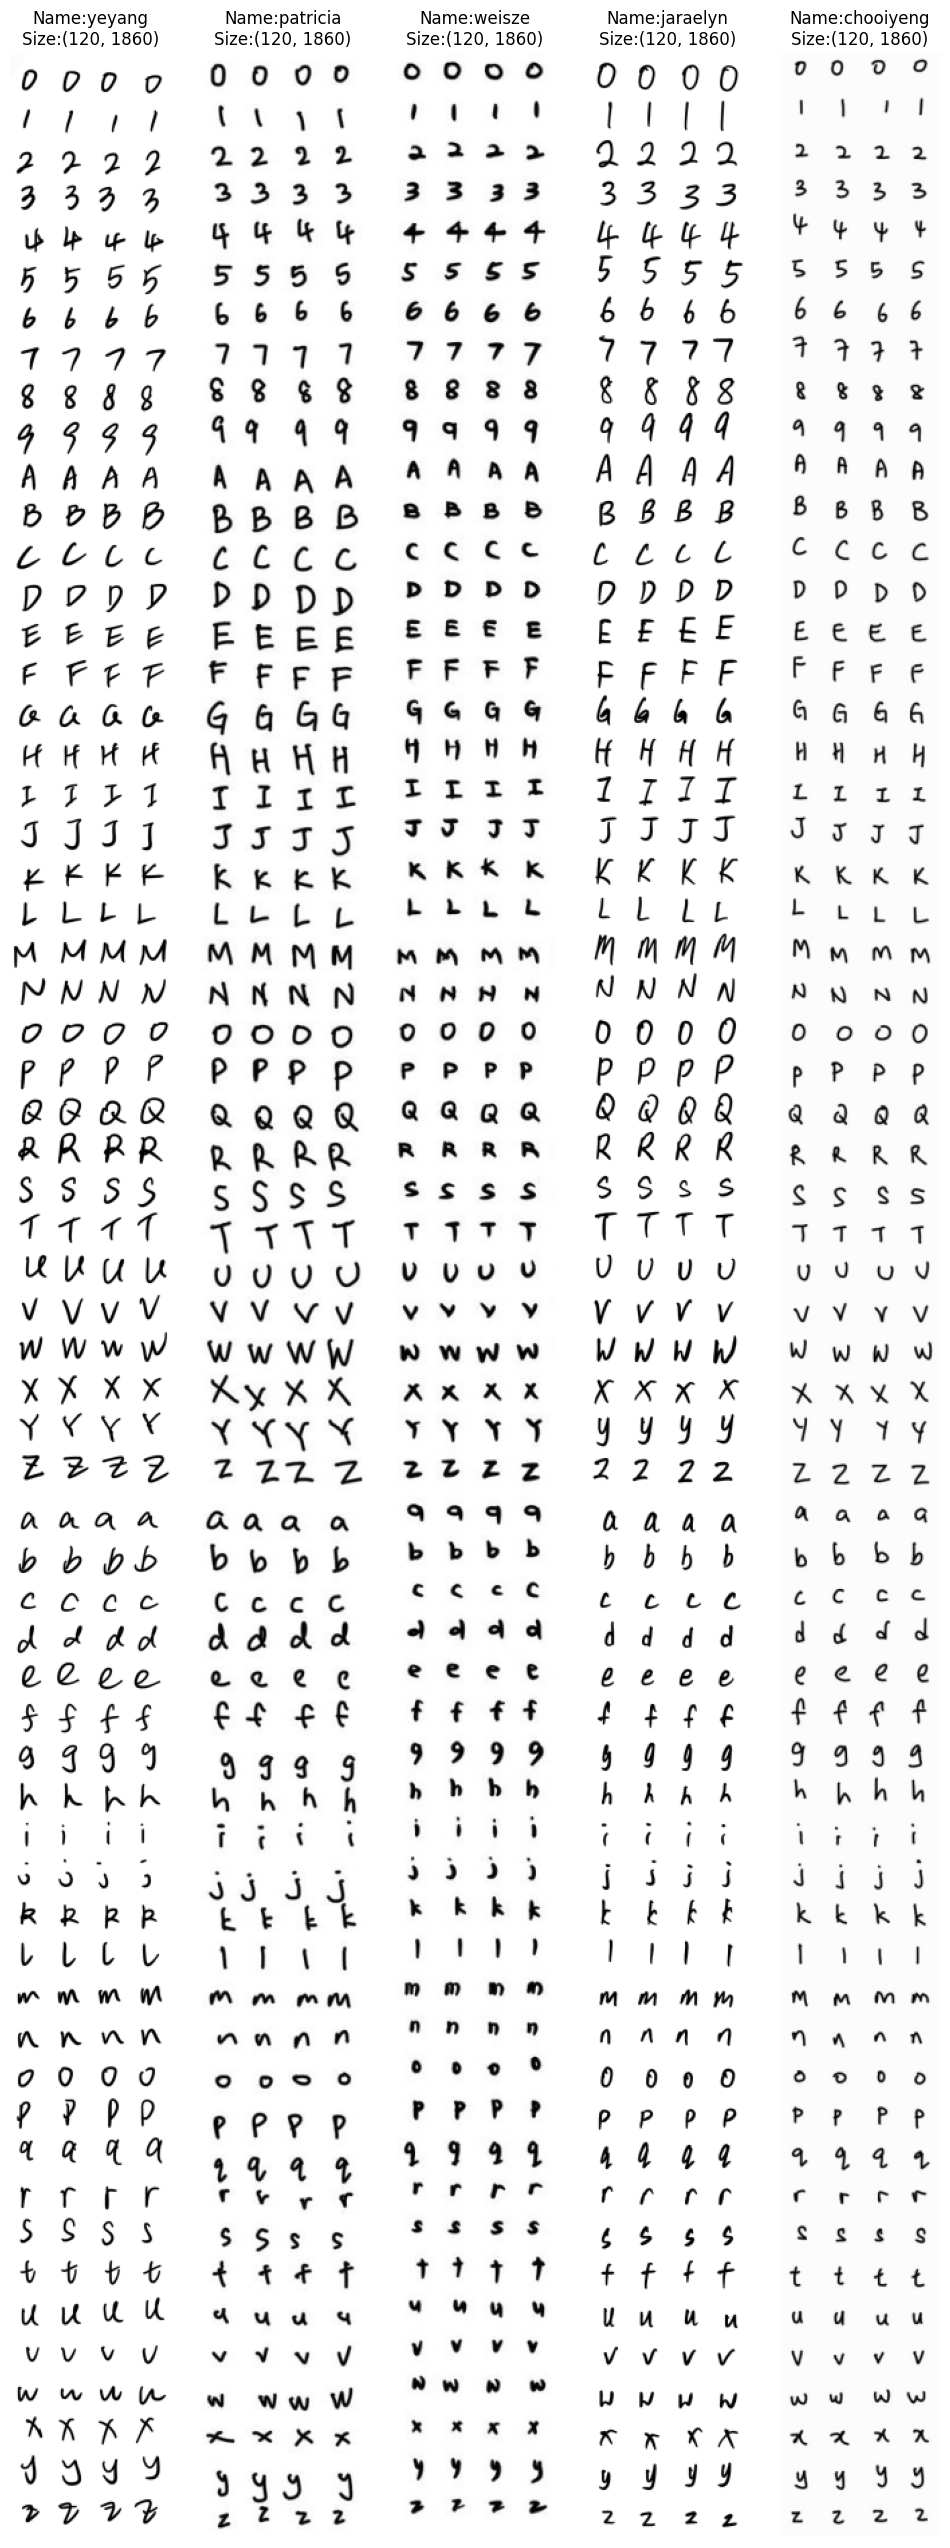

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(12, 186))
images = []
for ax, member in zip(axes, members):
    file_name = os.path.join(input_folder, member)
    image = Image.open(file_name)
    images.append(image)
    # Plot the image
    ax.set_title(f'Name:{member.split(".")[0]}\nSize:{image.size}')
    ax.imshow(image, cmap='gray')
    ax.axis('off')

# 3. Processing Raw Images into Dataset

Each written image is in the size of 120 * 1860, and each small digit is in the size of 30 * 30.

The preprocessing steps are as follows:
1. Change color mode to black-and-white, 256 shades.
2. Cut square images 30x30 pixels each.
3. Center Image
4. Save each small digit image into its corresponding label folder

## 3.1 Change color mode to black-and-white, 256 shades.

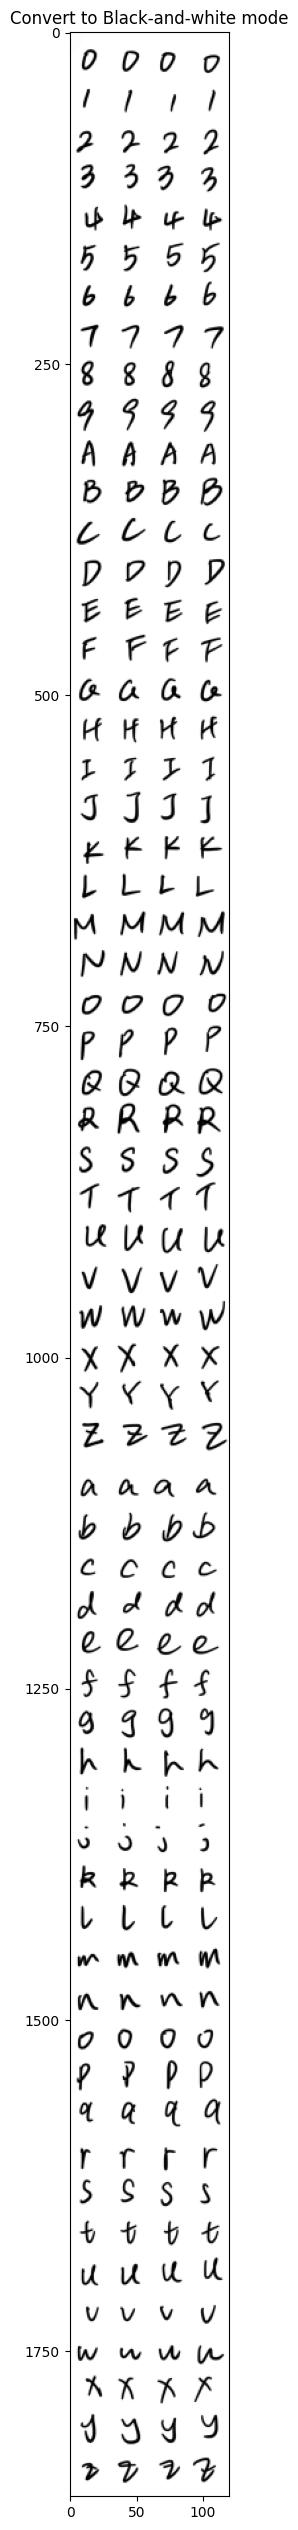

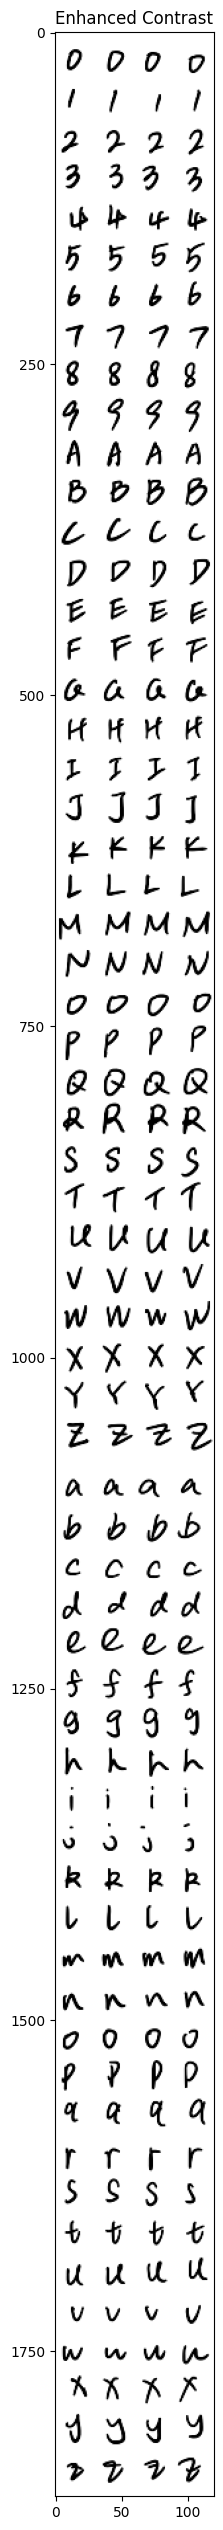

In [ ]:
bw_images = []
for index, image in enumerate(images):
    bw_image = image.convert('L')

    # plot example image for black-white mode
    if index == 0:
        show(bw_image, figsize=(12, 32), title="Convert to Black-and-white mode") #L is 8-bit black-and-white image mode
    bw_image = ImageEnhance.Contrast(bw_image).enhance(1.5)

    # plot example image for enhanced contrast
    if index == 0:
        show(bw_image, figsize=(12, 32), title="Enhanced Contrast")

    bw_images.append(bw_image)

## 3.2 Cut square images 30x30 pixels each.

In [ ]:
SIZE = 30
member_samples = [] #array to store cut images
for index, bw_image in enumerate(bw_images):
    samples = []
    print(f'Cutting digit for {members[index].split(".")[0]}:')
    for digit, y in enumerate(range(0, bw_image.height, SIZE)):
        cuts=[]
        for x in range(0, bw_image.width, SIZE):
            cut = bw_image.crop(box=(x, y, x+SIZE, y+SIZE))
            cuts.append(cut)
        samples.append(cuts)
    member_samples.append(samples)
    print(f'Cut {len(samples)*len(samples[0])} images total for {members[index].split(".")[0]}.')

Cutting digit for yeyang:
Cut 248 images total for yeyang.
Cutting digit for patricia:
Cut 248 images total for patricia.
Cutting digit for weisze:
Cut 248 images total for weisze.
Cutting digit for jaraelyn:
Cut 248 images total for jaraelyn.
Cutting digit for chooiyeng:
Cut 248 images total for chooiyeng.


## 3.3 plot several random images

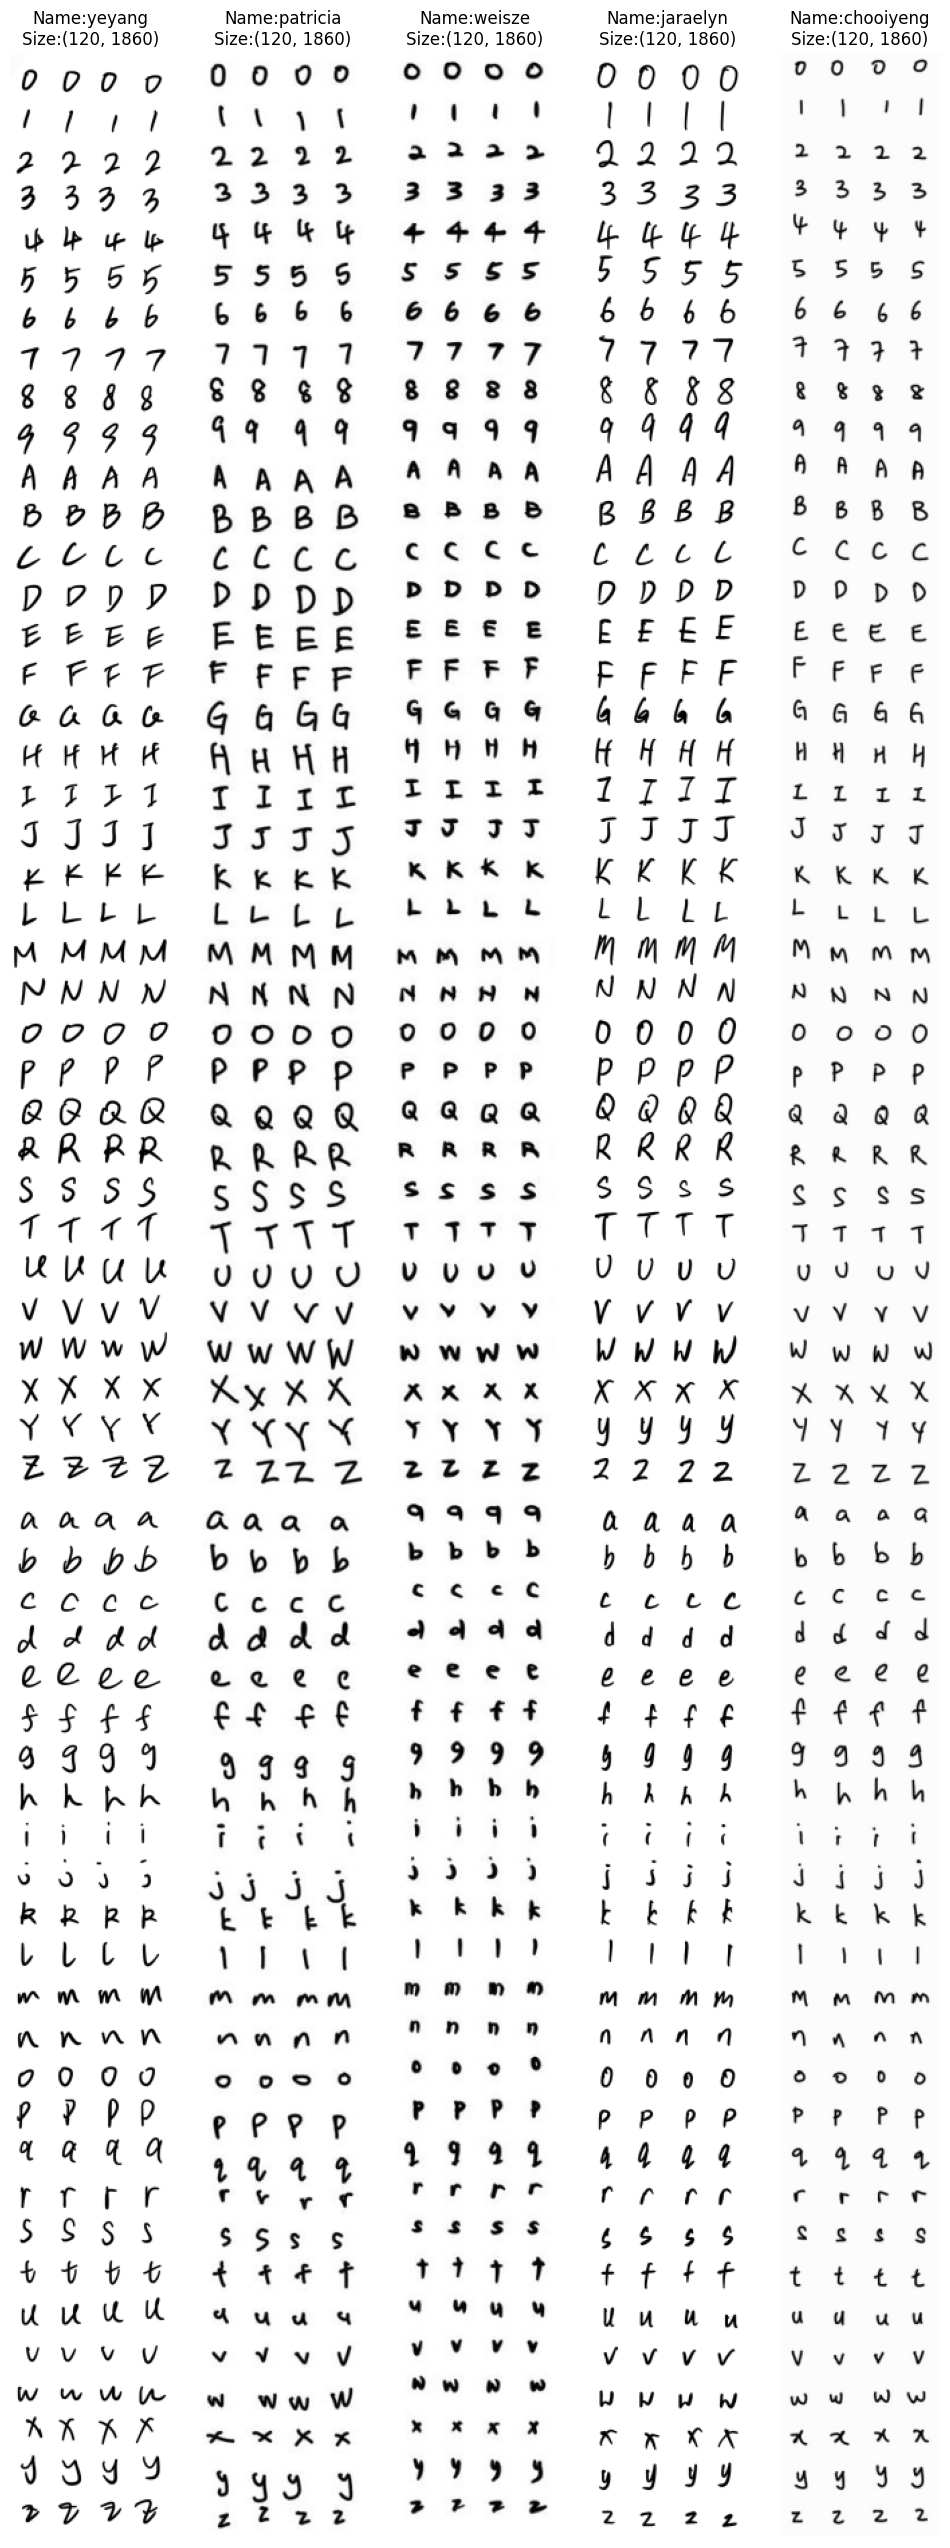

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(12, 186))
images = []
for ax, member in zip(axes, members):
    file_name = os.path.join(input_folder, member)
    image = Image.open(file_name)
    images.append(image)
    # Plot the image
    ax.set_title(f'Name:{member.split(".")[0]}\nSize:{image.size}')
    ax.imshow(image)
    ax.axis('off')

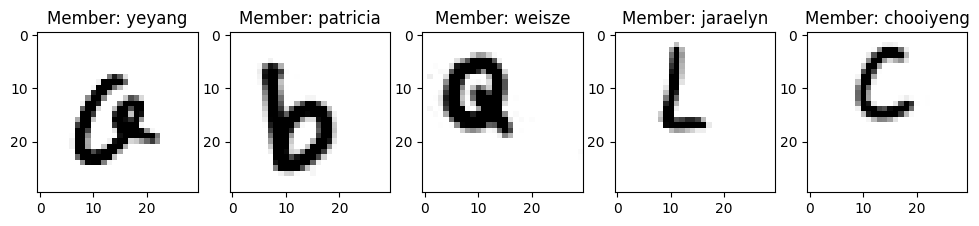

In [ ]:
fig, axes = plt.subplots(1, num_classes, figsize=(12, 12))
for i, samples in enumerate(member_samples):
    image = random.choice(list(chain(*samples)))
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Member: {members[i].split('.')[0]}")

## 3.4 Center Image

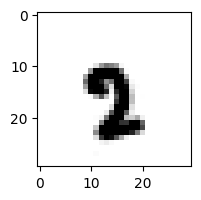

In [ ]:
sample = member_samples[1][2][2]
show(sample, figsize=(2, 2))

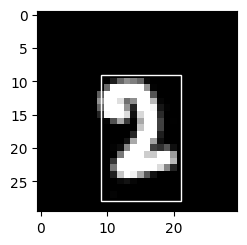

In [ ]:
# Inver sample, get bbox and display all that stuff.
inv_sample = ImageOps.invert(sample)
bbox = inv_sample.getbbox()

fig = plt.figure(figsize=(2, 2))
ax = fig.add_axes([0,0,1,1])

ax.imshow(inv_sample, cmap='gray')
rect = patches.Rectangle(
    (bbox[0], bbox[3]), bbox[2]-bbox[0], -bbox[3]+bbox[1]-1,
    fill=False, alpha=1, edgecolor='w')
ax.add_patch(rect)
plt.show()

Cropped Size: 12 * 18


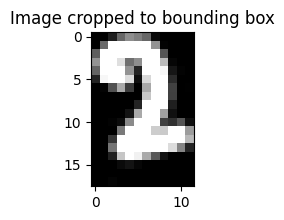

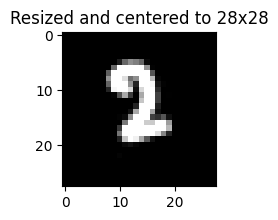

In [ ]:
crop = inv_sample.crop(bbox)
print(f"Cropped Size: {crop.size[0]} * {crop.size[1]}")
show(crop, title='Image cropped to bounding box',figsize=(2, 2))

#resize back
new_size = 28
delta_w = new_size - crop.size[0]
delta_h = new_size - crop.size[1]
delta = max(delta_w, delta_h)
padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
new_im = ImageOps.expand(crop, padding)
show(new_im, title='Resized and centered to 28x28', figsize=(2, 2))

In [ ]:
def resize_and_center(sample, new_size=28):
    inv_sample = ImageOps.invert(sample)
    bbox = inv_sample.getbbox()
    crop = inv_sample.crop(bbox)
    delta_w = new_size - crop.size[0]
    delta_h = new_size - crop.size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    return ImageOps.expand(crop, padding)

resized_samples_all = []
for samples in member_samples:
    resized_samples = []
    for row in samples:
        resized_samples.append([resize_and_center(sample) for sample in row])
    resized_samples_all.append(resized_samples)

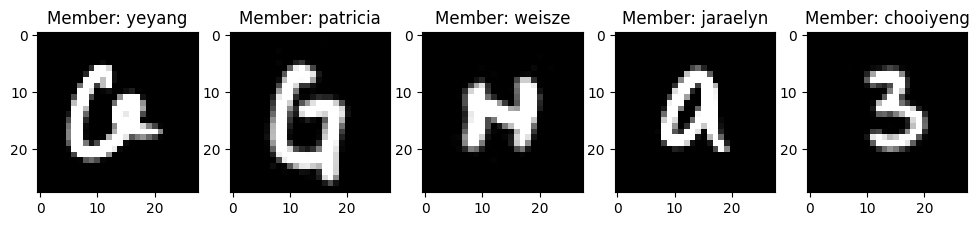

In [ ]:
fig, axes = plt.subplots(1, num_classes, figsize=(12, 12))
for i, samples in enumerate(resized_samples_all):
    image = random.choice(list(chain(*samples)))
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Member: {members[i].split('.')[0]}")

## 3.5 Previews

In [ ]:
!mkdir digits_preview

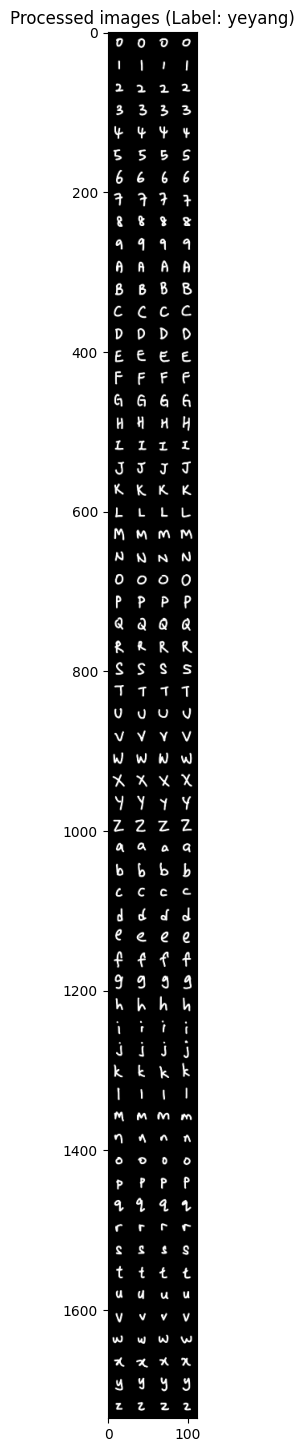

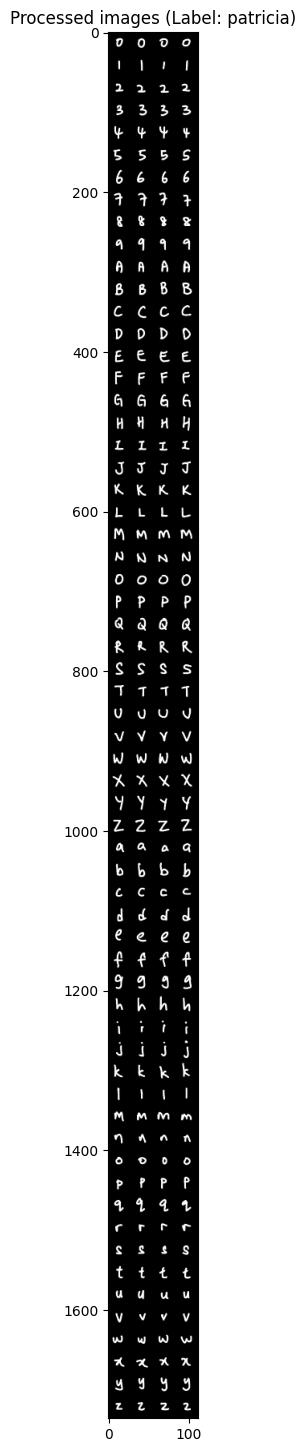

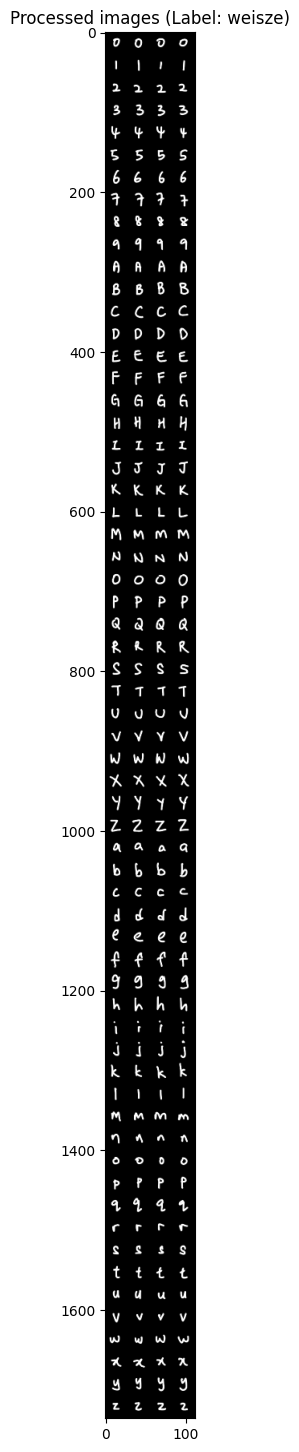

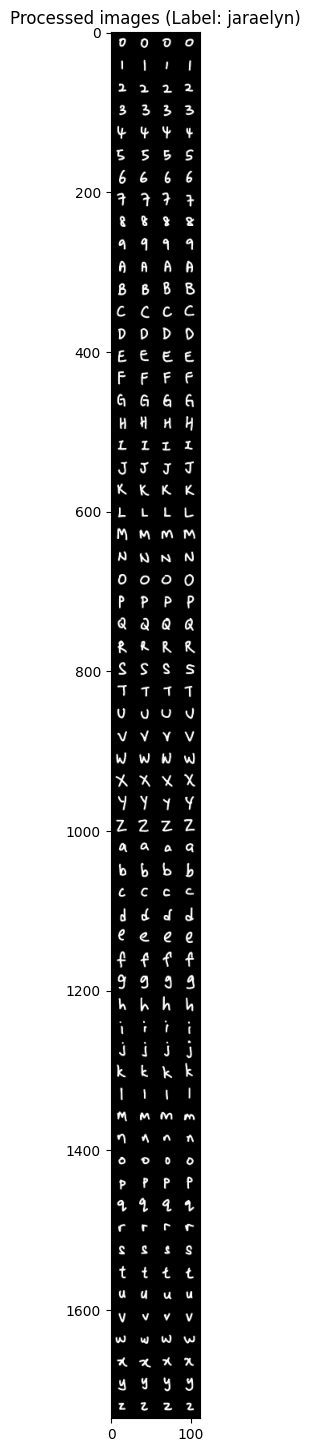

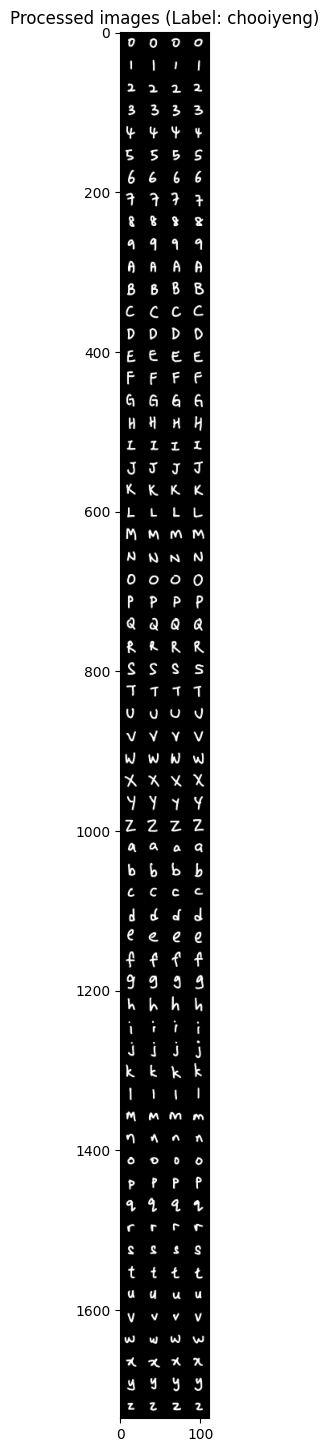

In [ ]:
for member, samples in zip(members, resized_samples_all):
    preview = Image.new('L', (len(samples[0])*new_size, len(samples)*new_size))

    x = 0
    y = 0
    for row in resized_samples:
        for sample in row:
            preview.paste(sample, (x, y))
            x += new_size
        y+=new_size
        x = 0

    show(preview, figsize=(18,18), title=f'Processed images (Label: {member.split(".")[0]})')
    preview.save(os.path.join('digits_preview', f'{member.split(".")[0]}_preview.png'))

## 3.6 Save Dataset
After cutting the large image into each individual digits, they are saved into its folder in jpg format

In [ ]:
!mkdir datasets

mkdir: cannot create directory ‘datasets’: File exists


In [ ]:
for index, resized_samples in enumerate(resized_samples_all):
    member_name = members[index].split('.')[0]
    folder = os.path.join('datasets', member_name)
    if not os.path.exists(folder):
        os.mkdir(folder)
    for i, image in enumerate(chain(*resized_samples)):
        image.save(os.path.join(folder, f"digit_{i}.jpg"))

# 4 Classification Model

## 4.0 Model Settings

In [ ]:
batch_size = 64
num_epochs = 60
device = torch.device('cpu')
data_dir = 'datasets'

torch.manual_seed(11)

## 4.1 Display Dataset

Label: yeyang


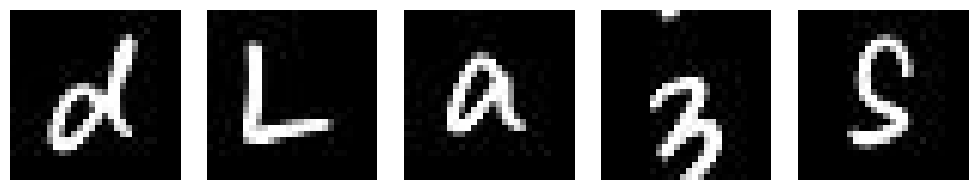

Label: jaraelyn


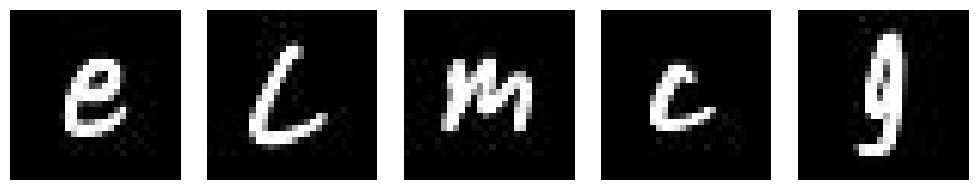

Label: chooiyeng


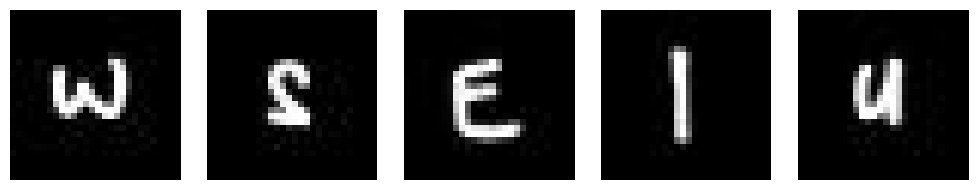

Label: patricia


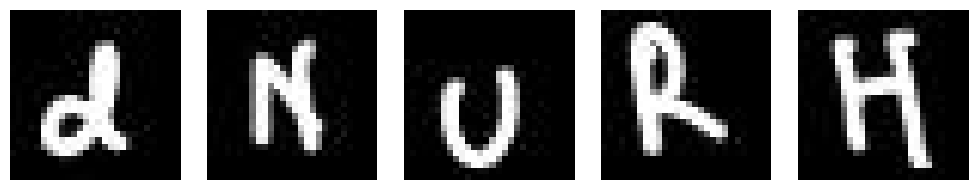

Label: weisze


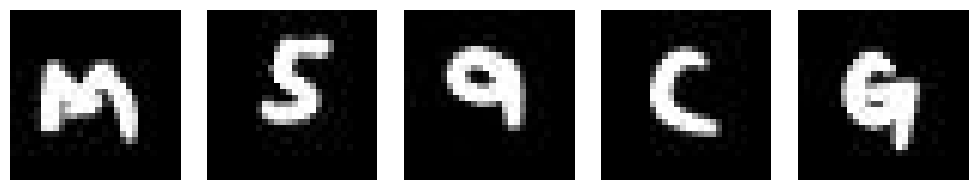

In [ ]:
for i in os.listdir(data_dir):
    path = os.path.join(data_dir, i)
    images = random.sample(os.listdir(path), num_classes)
    images = [os.path.join(path, i) for i in images]
    fig, axes = plt.subplots(1, num_classes, figsize=(10, 2))

    # Plot each image in a separate subplot
    print(f"Label: {i}")
    for i, ax in enumerate(axes):
        image_path = images[i]
        image = Image.open(image_path)
        image_array = np.array(image)  # Convert image to numpy array

        ax.imshow(image_array, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## 4.1 Load Data

In [ ]:
# dataset class to load images from their corresponding folders
class MNISTDataset(Dataset):
    # defining values in the constructor
    def __init__(self, path, transforms = None):
        self.path = path
        self.transform = transforms
        self.classes = os.listdir(path)
        self.label2class = dict(zip(list(range(len(self.classes))), self.classes))
        self.class2label = dict(zip(self.classes, list(range(len(self.classes)))))

        self.images = []
        self.clses = []
        self.labels = []

        for cls in self.classes:
            examples = os.listdir(os.path.join(path, cls))
            self.images.extend(examples)
            self.clses.extend([cls] * len(examples))
            self.labels.extend([self.class2label[cls]] * len(examples))

    # Getting the data samples
    def __getitem__(self, idx):
        image_name = os.path.join(self.path, self.clses[idx], self.images[idx])
        image = Image.open(image_name)
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(image)
        return sample, label

    # Getting data size/length
    def __len__(self):
        return len(self.labels)

In [ ]:
# transformation to each image
transform = transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [ ]:
# get dataset
dataset = MNISTDataset('datasets', transform)

In [ ]:
train_data, test_data = train_test_split(dataset, test_size=0.2016, random_state=0, stratify=dataset.labels) # split data based on labels
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## 4.2 Model Architecture

Model Structure
- Convolutional Layers
  - 2d Convolutional Layer
  - Max Pooling Layer
  - ReLU Activation Layer
  - 2d Convolutional Layer
  - Dropout Lauer
  - Max Pooling Layer
  - ReLU Activation Layer
- Fully Connected Layers
  - Linear Layer
  - ReLU Activation Layer
  - Dropout Layer
  - Linear Layer
  - Softmax Lauer

In [ ]:
class CNN_MODEL(nn.Module):
    def __init__(self):
        super(CNN_MODEL, self).__init__()

        # conv layer
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        # mlp layers
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

## 4.3 Train and Test method

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
    count = 0
    train_loss = 0
    with torch.no_grad():
        for data, target in train_loader:
            count += len(target)
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
    train_loss /= count
    print('Train Epoch: {}  \t Avg Loss: {:.6f}'.format(
        epoch, train_loss), end='\t')
    return train_loss


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test Avg Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    return test_loss


def plot_loss(train_loss, test_loss):
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train loss', 'test loss'])
    plt.title('Train Loss vs. Test Loss')
    plt.show()

## 4.4 Training

In [ ]:
train_losses = []
test_losses = []

model = CNN_MODEL().to(device)
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, num_epochs + 1):
    train_losses.append(train(model, device, train_loader, optimizer, epoch))
    test_losses.append(test(model, device, test_loader))

Train Epoch: 1  	 Avg Loss: 0.029636	Test Avg Loss: 0.0280, Accuracy: 61/250 (24%)

Train Epoch: 2  	 Avg Loss: 0.027235	Test Avg Loss: 0.0279, Accuracy: 73/250 (29%)

Train Epoch: 3  	 Avg Loss: 0.025036	Test Avg Loss: 0.0250, Accuracy: 108/250 (43%)

Train Epoch: 4  	 Avg Loss: 0.022358	Test Avg Loss: 0.0233, Accuracy: 125/250 (50%)

Train Epoch: 5  	 Avg Loss: 0.020532	Test Avg Loss: 0.0206, Accuracy: 136/250 (54%)

Train Epoch: 6  	 Avg Loss: 0.019243	Test Avg Loss: 0.0195, Accuracy: 134/250 (54%)

Train Epoch: 7  	 Avg Loss: 0.017099	Test Avg Loss: 0.0175, Accuracy: 148/250 (59%)

Train Epoch: 8  	 Avg Loss: 0.016563	Test Avg Loss: 0.0165, Accuracy: 153/250 (61%)

Train Epoch: 9  	 Avg Loss: 0.015122	Test Avg Loss: 0.0158, Accuracy: 153/250 (61%)

Train Epoch: 10  	 Avg Loss: 0.014454	Test Avg Loss: 0.0148, Accuracy: 160/250 (64%)

Train Epoch: 11  	 Avg Loss: 0.013620	Test Avg Loss: 0.0137, Accuracy: 162/250 (65%)

Train Epoch: 12  	 Avg Loss: 0.012459	Test Avg Loss: 0.0132, Accu

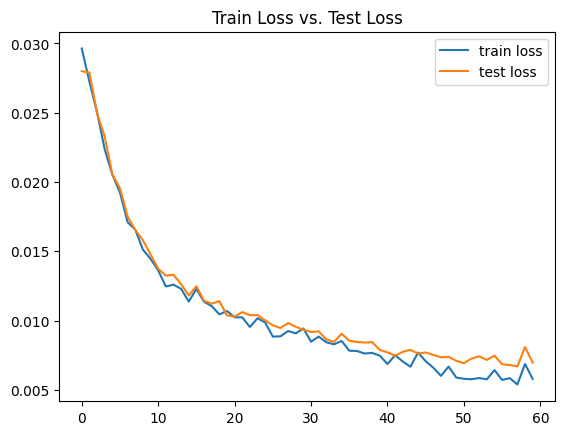

In [ ]:
plot_loss(train_losses, test_losses)

# 5. Explainable Information

In [ ]:
!pip install -q shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 19.5 MB/s eta 0:00:00


In [ ]:
def SHAP_plot(model):
    model.eval()
    batch = next(iter(train_loader))
    images, _ = batch

    background = images[:15]
    test_images = images[15:20]

    e = shap.DeepExplainer(model, background)
    shap_values = e.shap_values(test_images)

    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


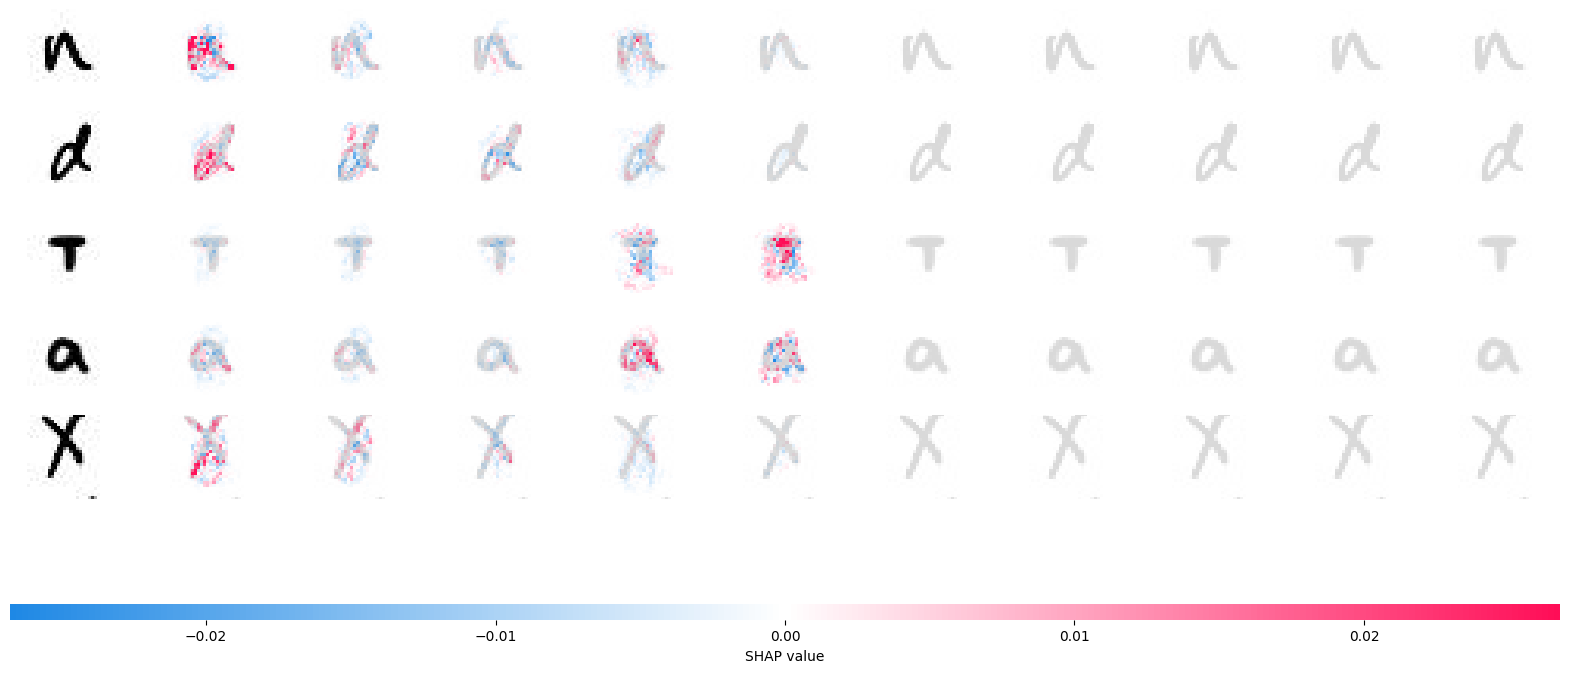

In [ ]:
SHAP_plot(model)

# 6. Analysis

In [ ]:
label2class = dataset.label2class
classes = label2class.values()

def analyze(model, device, test_loader):
    model.eval()
    targets = []
    preds = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            targets.extend([t.item() for t in target])
            preds.extend([p.item() for p in pred])

    matrix = confusion_matrix(targets, preds)
    accuracy_scores = matrix.diagonal()/matrix.sum(axis=1)

    print("Report:")
    for i in range(num_classes):
        print(f"{label2class[i]} - Accuracy Score {accuracy_scores[i]}")
        for j in range(num_classes):
            if i != j:
                print(f"\t{matrix[i][j]} was wrongly classifed as {label2class[j]}")
            else:
                print(f"\t{matrix[i][j]} was correctly classified")
        print()

    print("Confusion Matrix")

    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = matrix.max() / 2.0
    for i, j in np.ndindex(matrix.shape):
        plt.text(j, i, format(matrix[i, j], 'd'),
                horizontalalignment="center",
                color="white" if matrix[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

Report:
yeyang - Accuracy Score 0.76
	38 was correctly classified
	10 was wrongly classifed as jaraelyn
	2 was wrongly classifed as chooiyeng
	0 was wrongly classifed as patricia
	0 was wrongly classifed as weisze

jaraelyn - Accuracy Score 0.64
	14 was wrongly classifed as yeyang
	32 was correctly classified
	4 was wrongly classifed as chooiyeng
	0 was wrongly classifed as patricia
	0 was wrongly classifed as weisze

chooiyeng - Accuracy Score 0.84
	7 was wrongly classifed as yeyang
	1 was wrongly classifed as jaraelyn
	42 was correctly classified
	0 was wrongly classifed as patricia
	0 was wrongly classifed as weisze

patricia - Accuracy Score 0.98
	0 was wrongly classifed as yeyang
	0 was wrongly classifed as jaraelyn
	0 was wrongly classifed as chooiyeng
	49 was correctly classified
	1 was wrongly classifed as weisze

weisze - Accuracy Score 0.82
	0 was wrongly classifed as yeyang
	0 was wrongly classifed as jaraelyn
	0 was wrongly classifed as chooiyeng
	9 was wrongly classifed as

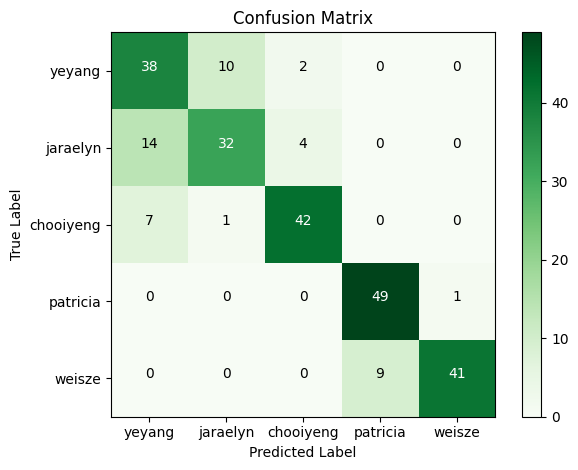

In [ ]:
analyze(model, device, test_loader)

In [ ]:
def display_misclassified(img, true, pred, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.title(f"{true} misclassified as {pred}")

In [ ]:
def misclassified_report(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    targets = []
    preds = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            for d, t in zip(data, target):
                output = model(d)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                if pred != t:
                    display_misclassified(d.reshape(28, 28), label2class[t.item()], label2class[pred.item()])

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


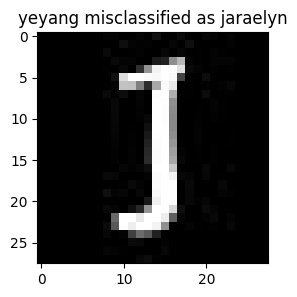

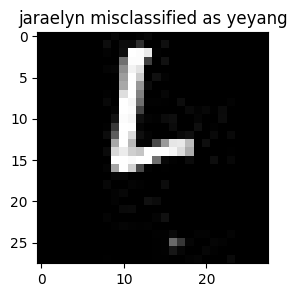

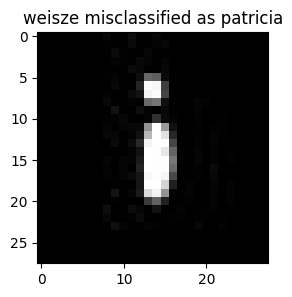

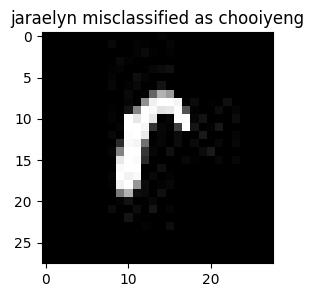

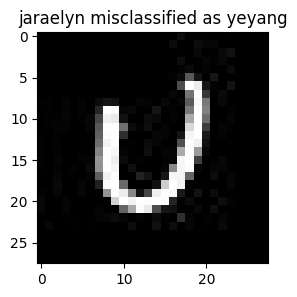

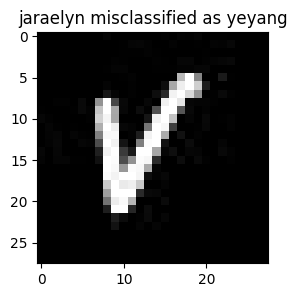

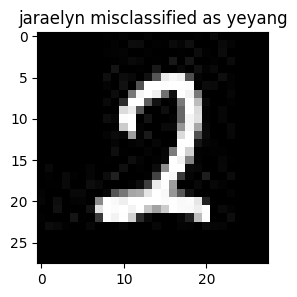

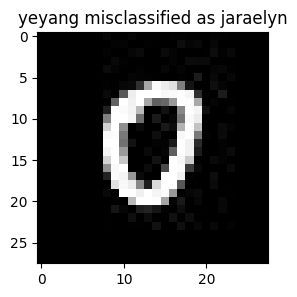

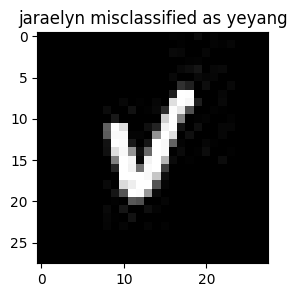

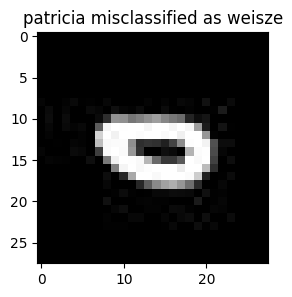

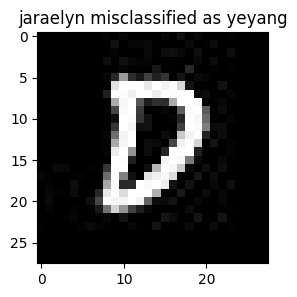

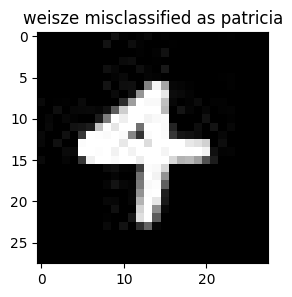

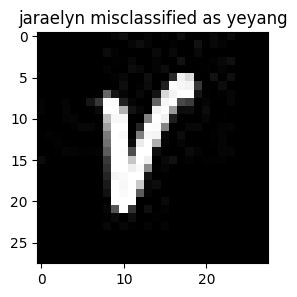

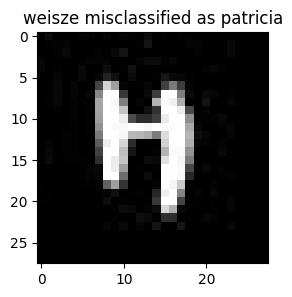

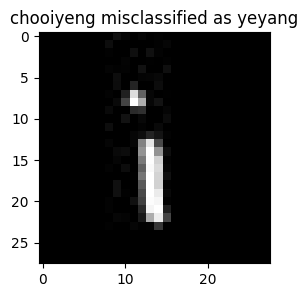

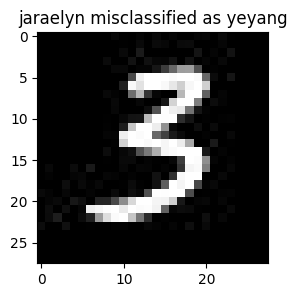

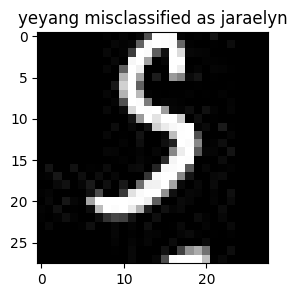

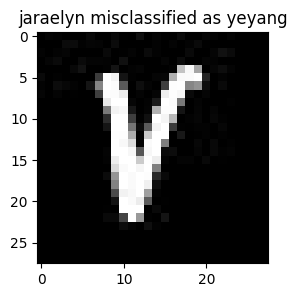

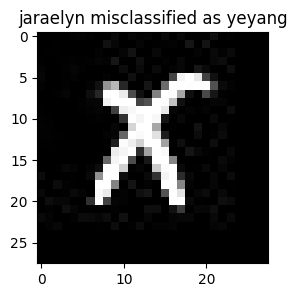

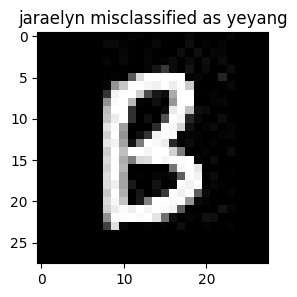

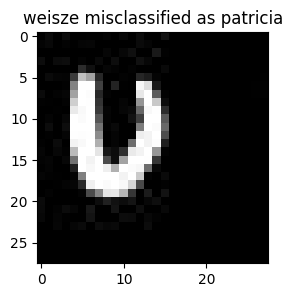

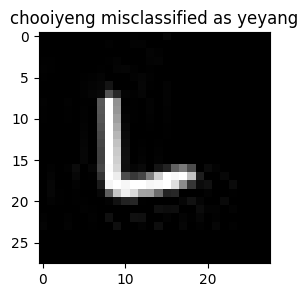

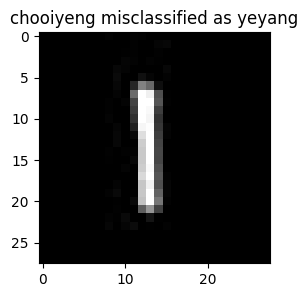

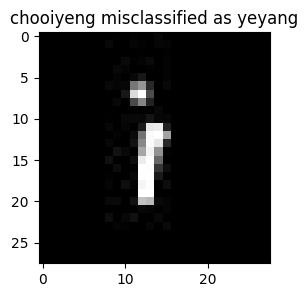

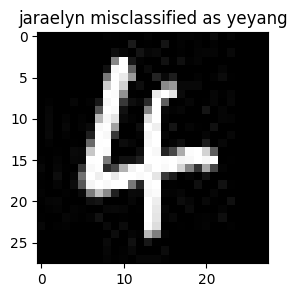

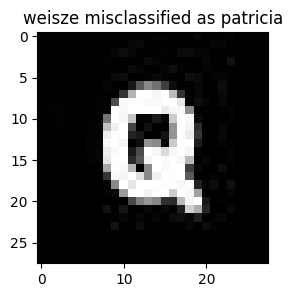

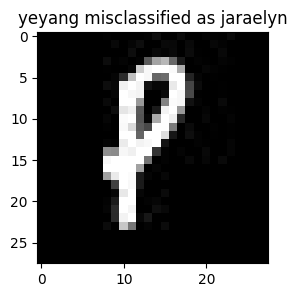

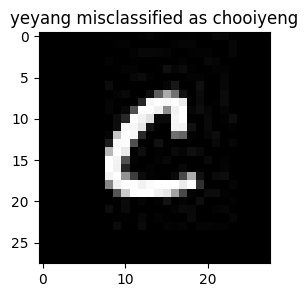

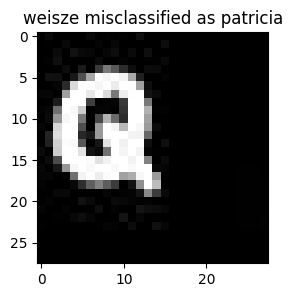

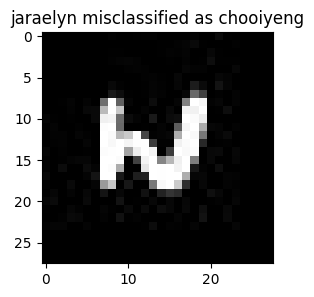

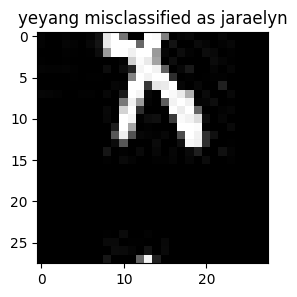

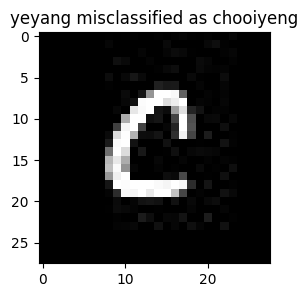

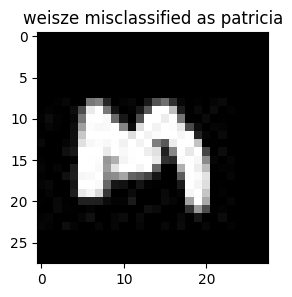

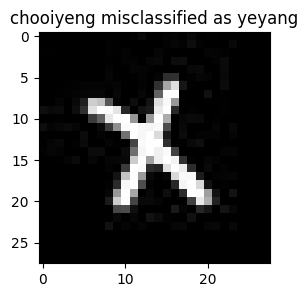

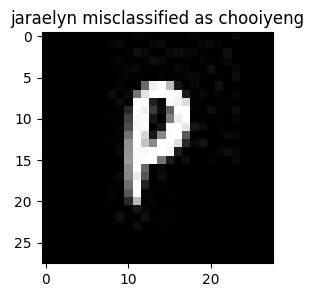

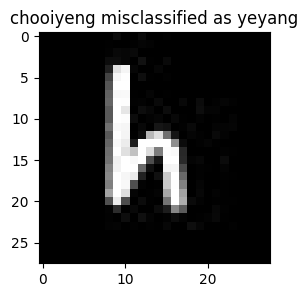

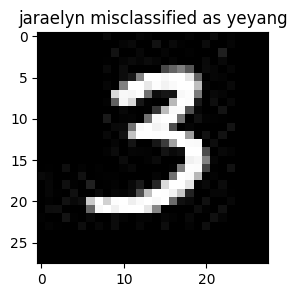

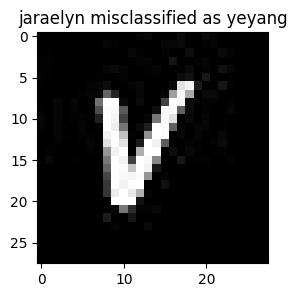

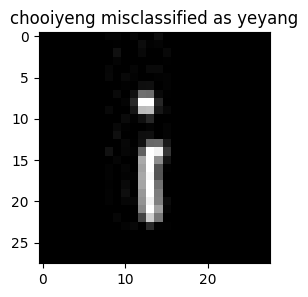

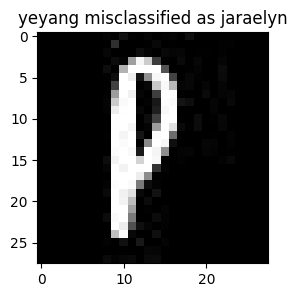

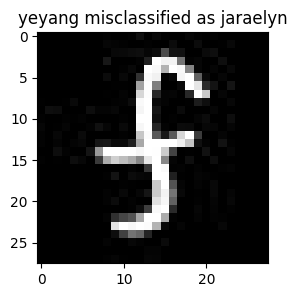

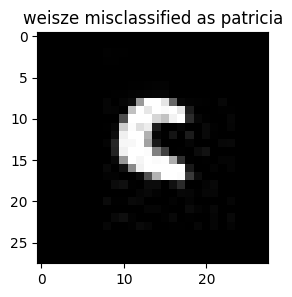

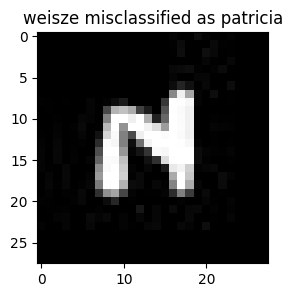

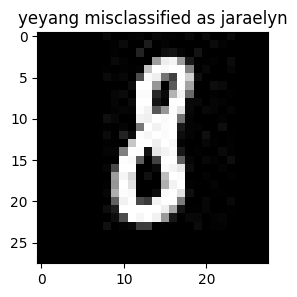

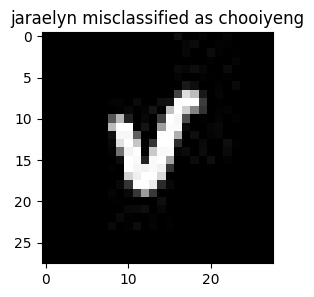

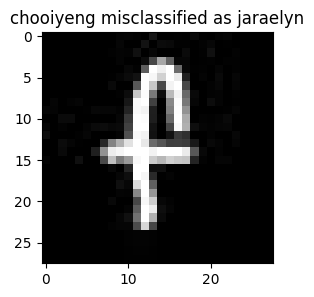

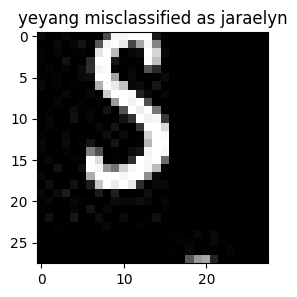

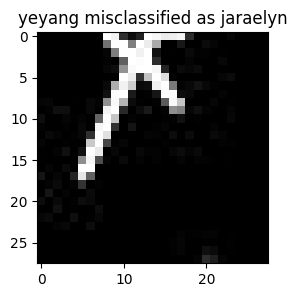

In [ ]:
misclassified_report(model, device, test_loader)

In [ ]:
def display_classified(img, true, pred, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.title(f"{true} classified as {true}")

In [ ]:
def classified_report(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    targets = []
    preds = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            for d, t in zip(data, target):
                output = model(d)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                if pred == t:
                    display_classified(d.reshape(28, 28), label2class[t.item()], label2class[pred.item()])

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


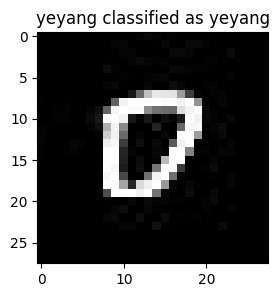

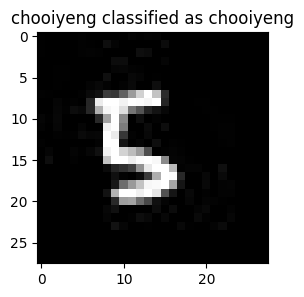

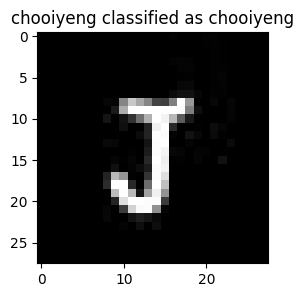

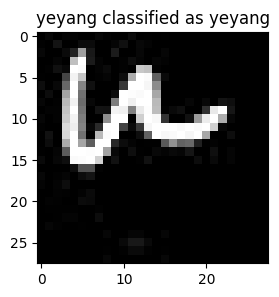

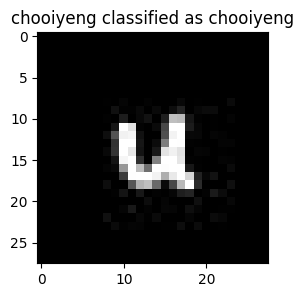

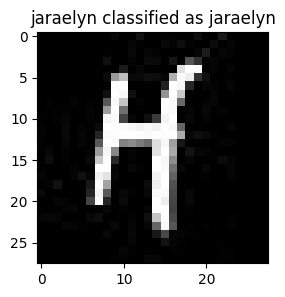

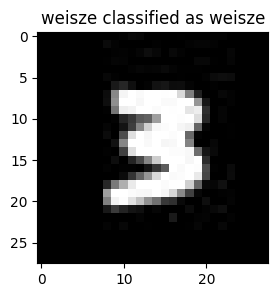

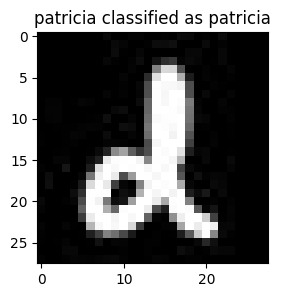

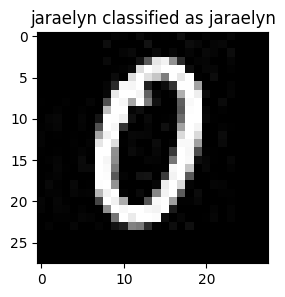

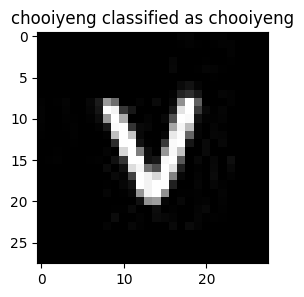

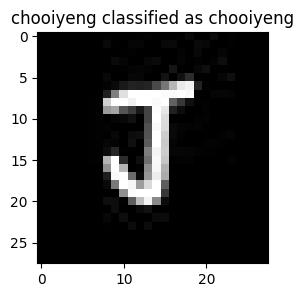

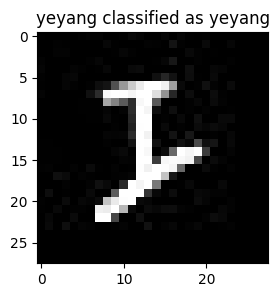

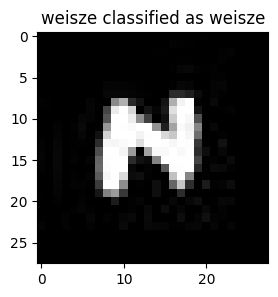

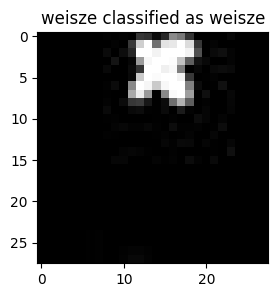

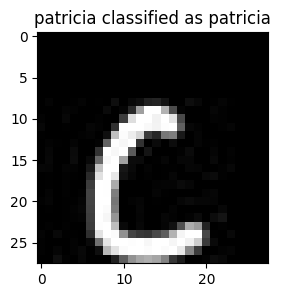

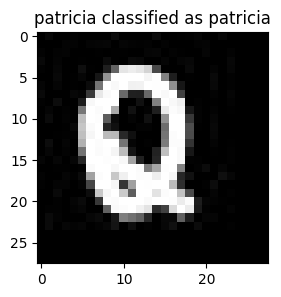

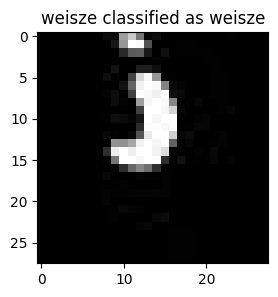

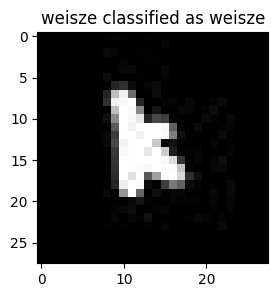

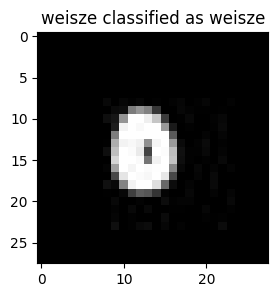

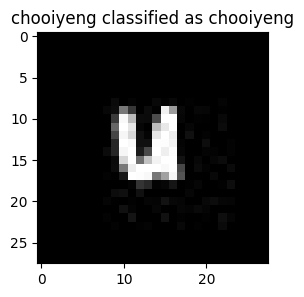

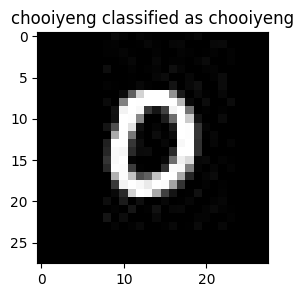

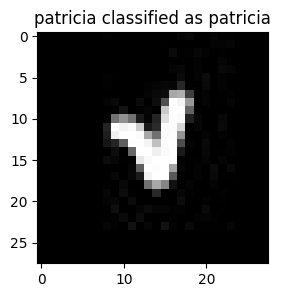

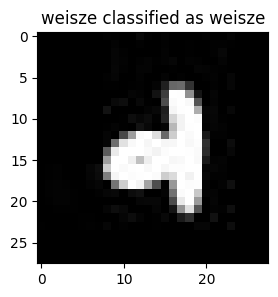

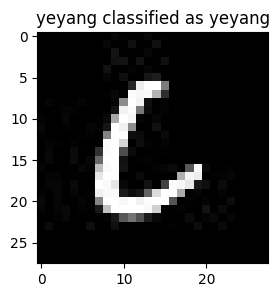

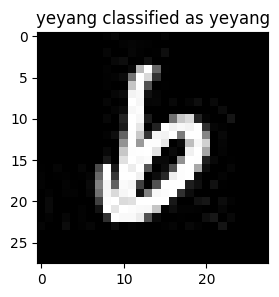

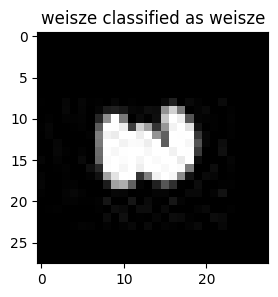

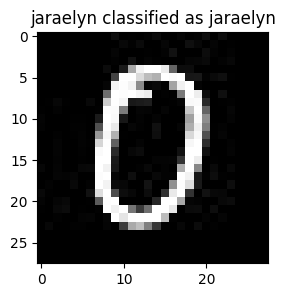

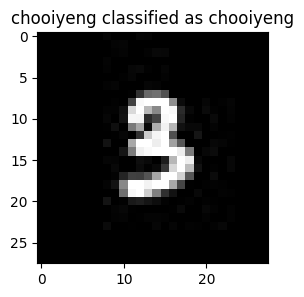

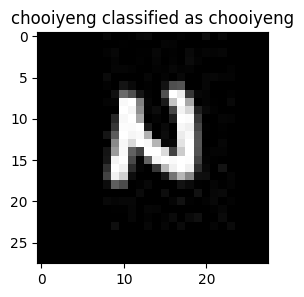

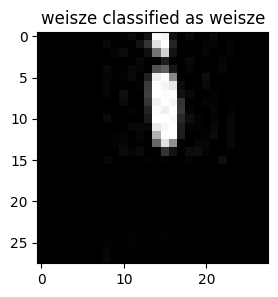

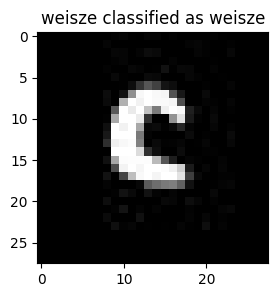

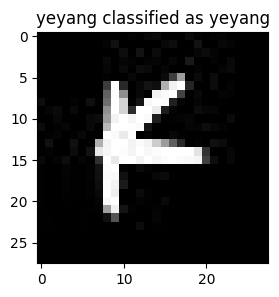

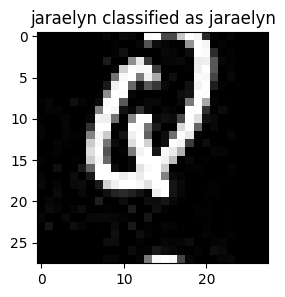

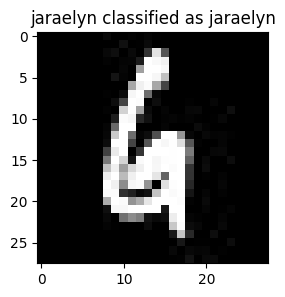

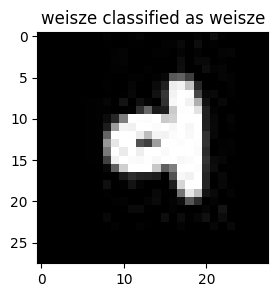

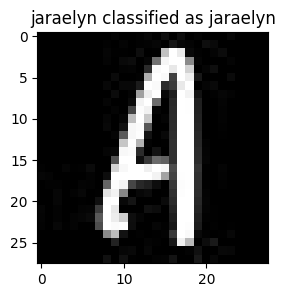

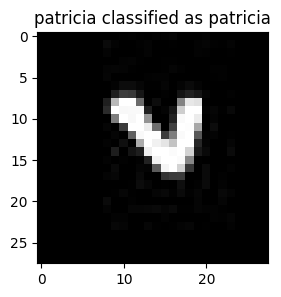

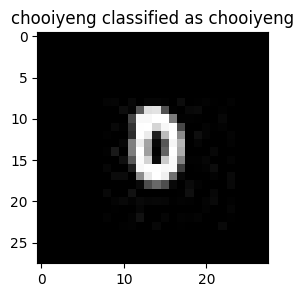

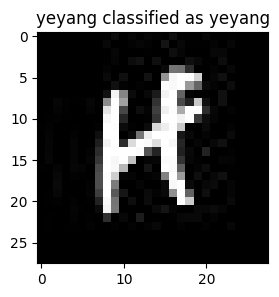

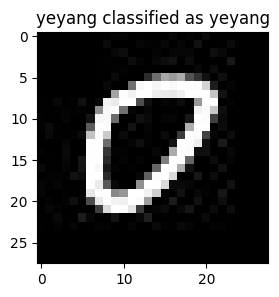

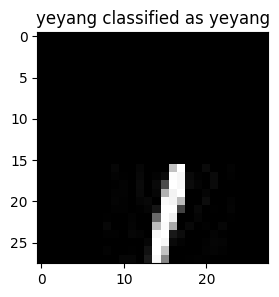

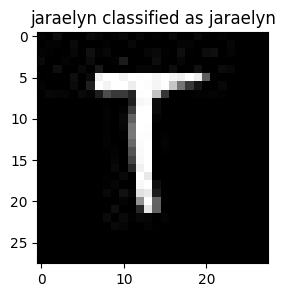

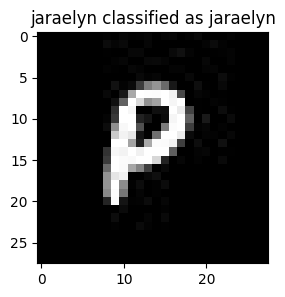

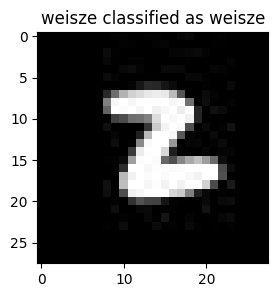

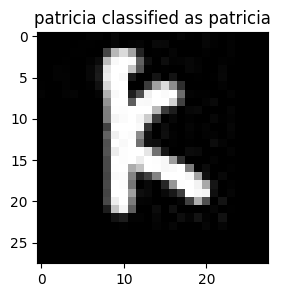

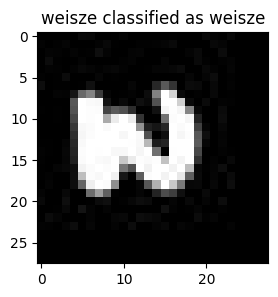

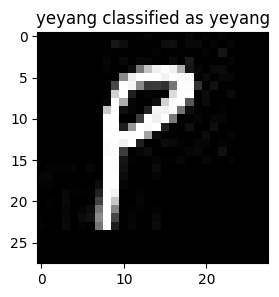

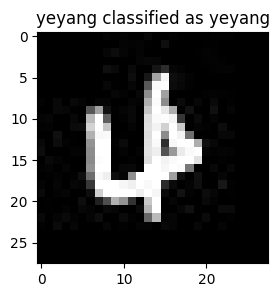

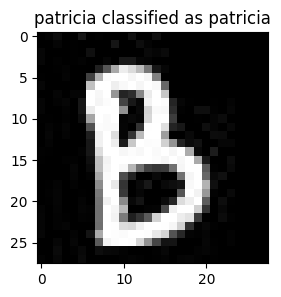

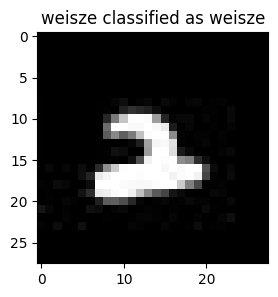

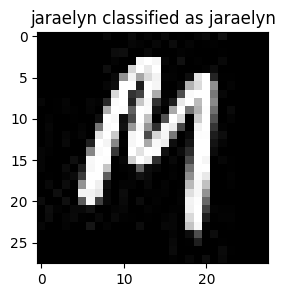

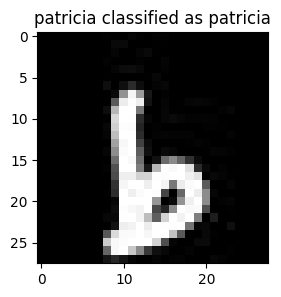

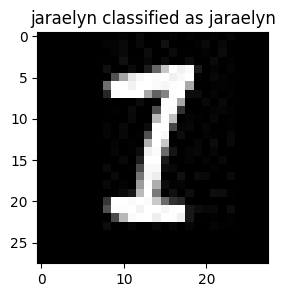

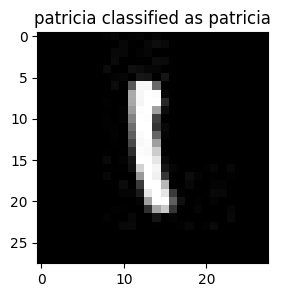

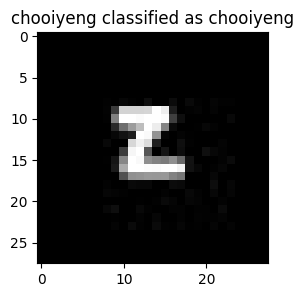

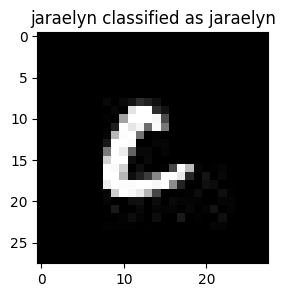

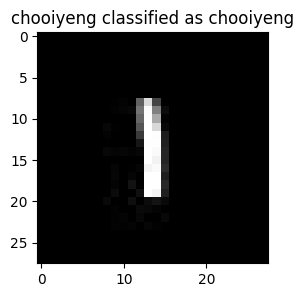

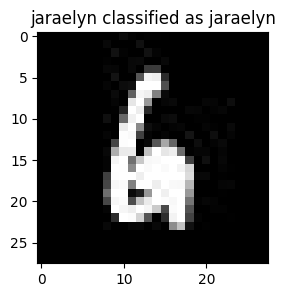

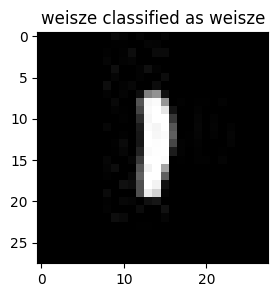

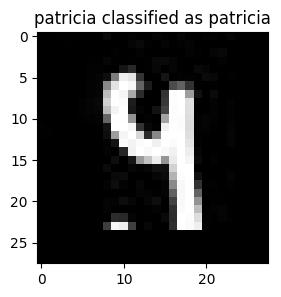

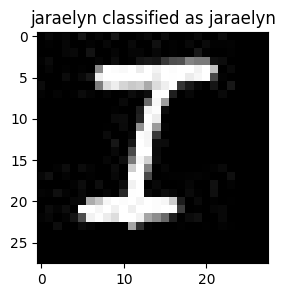

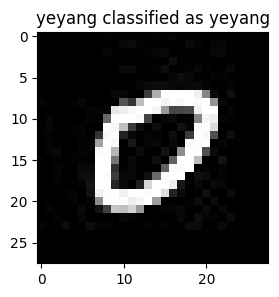

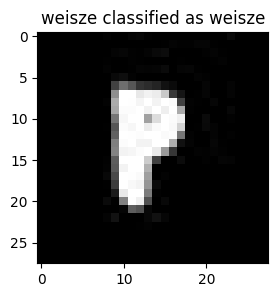

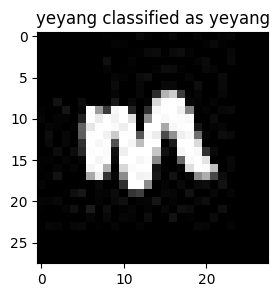

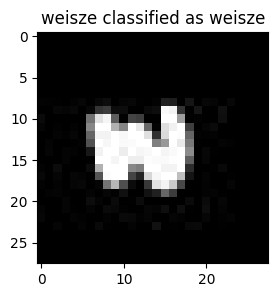

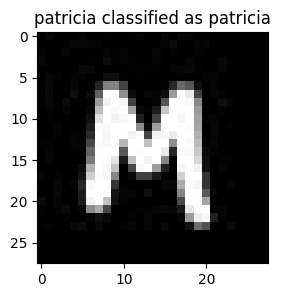

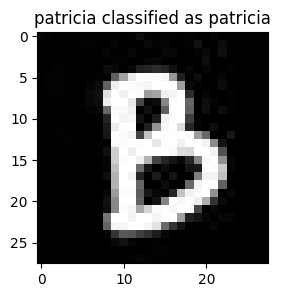

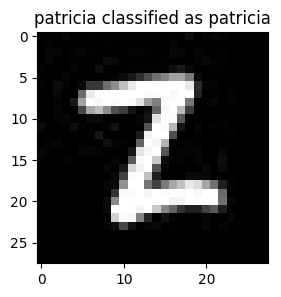

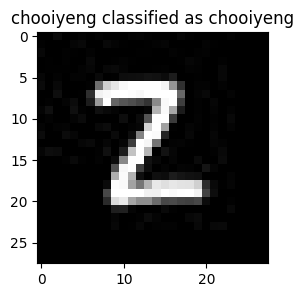

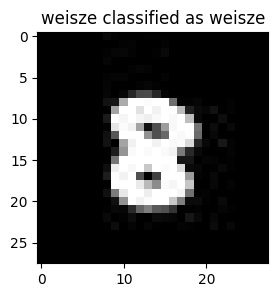

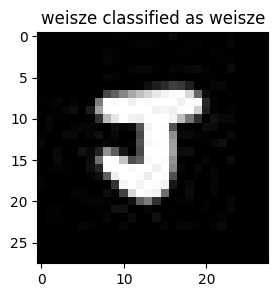

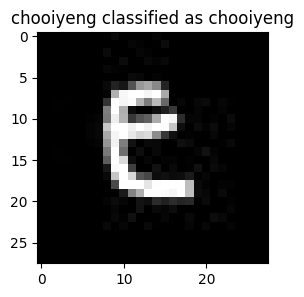

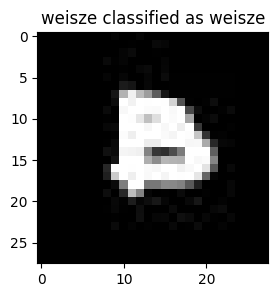

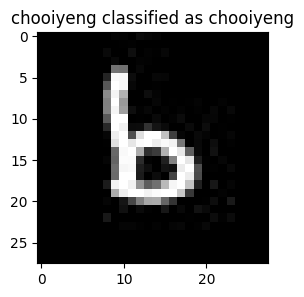

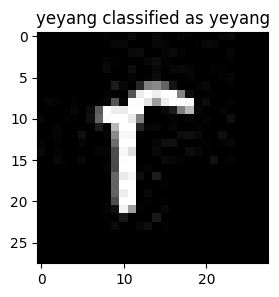

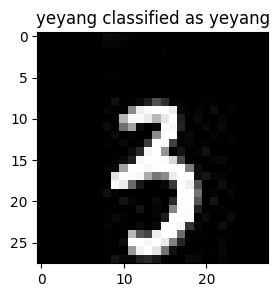

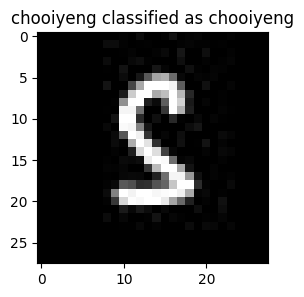

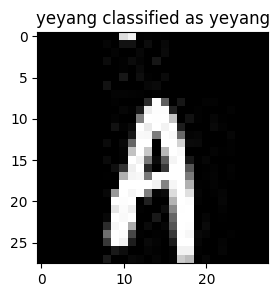

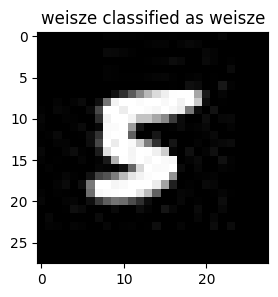

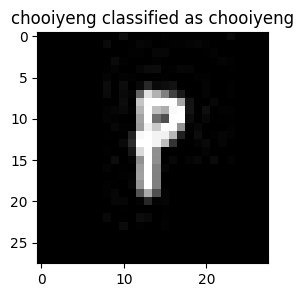

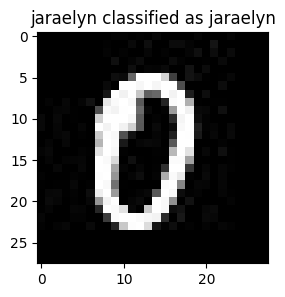

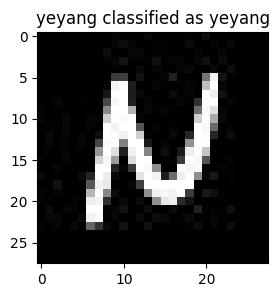

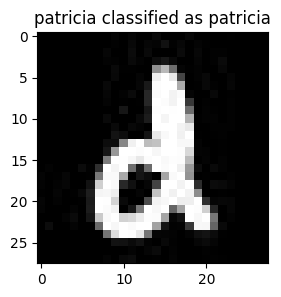

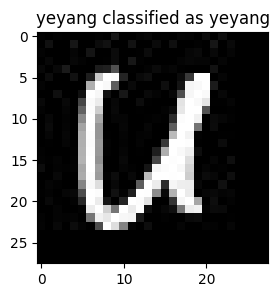

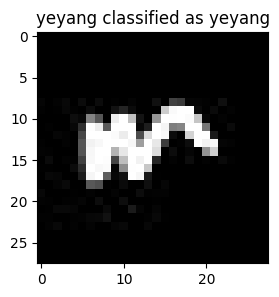

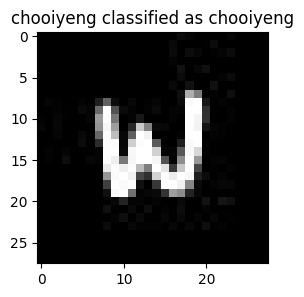

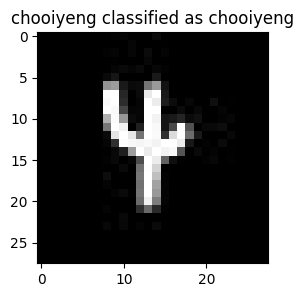

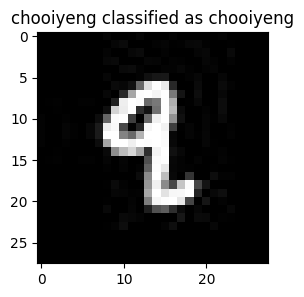

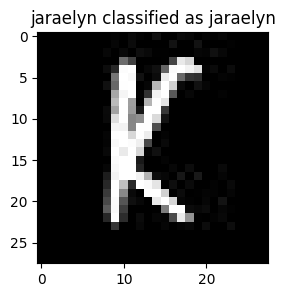

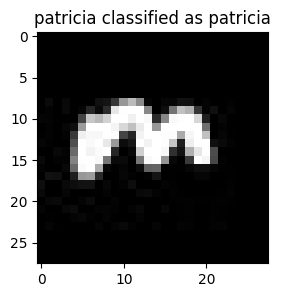

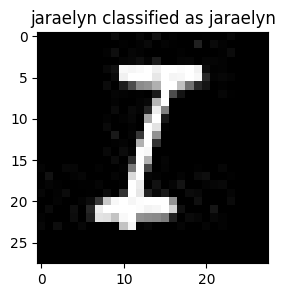

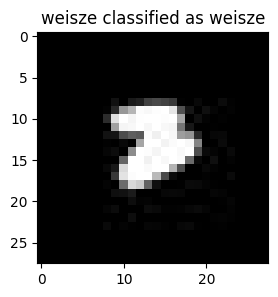

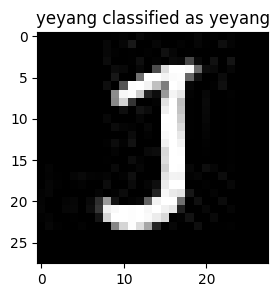

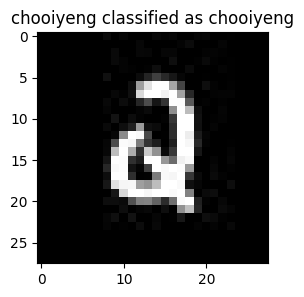

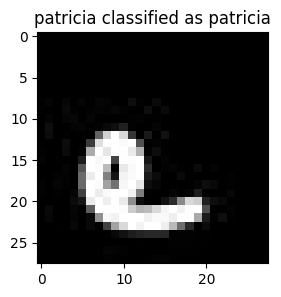

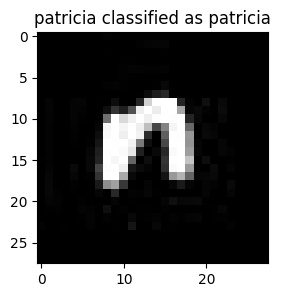

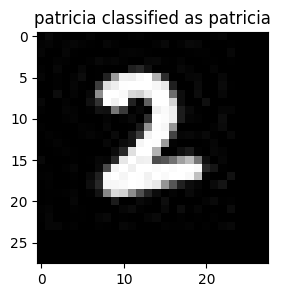

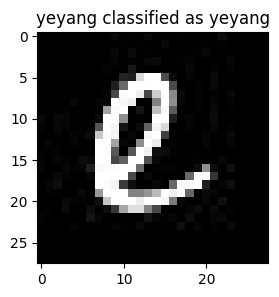

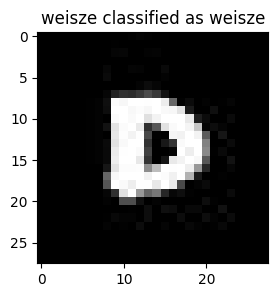

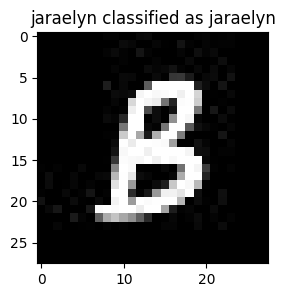

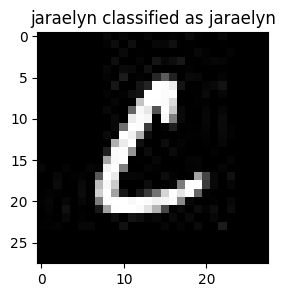

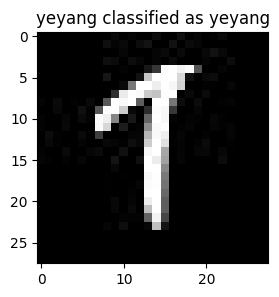

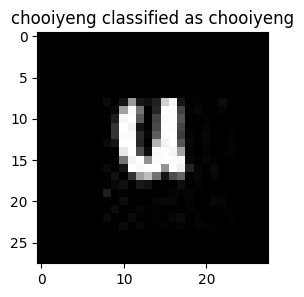

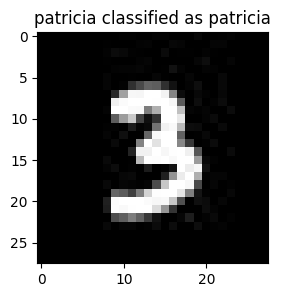

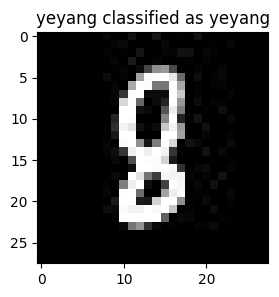

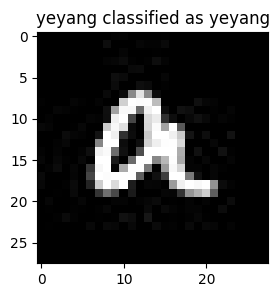

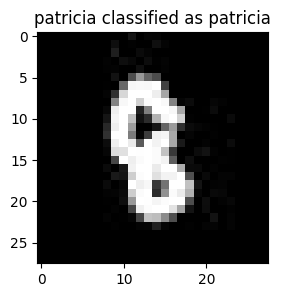

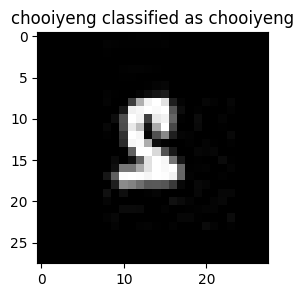

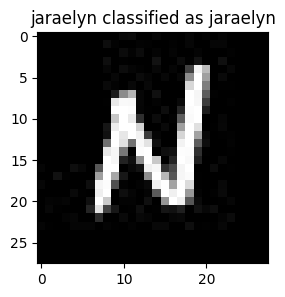

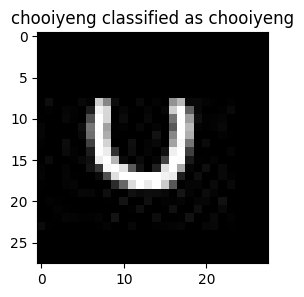

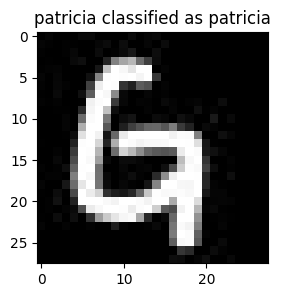

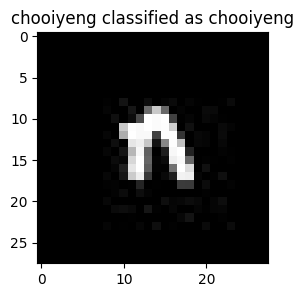

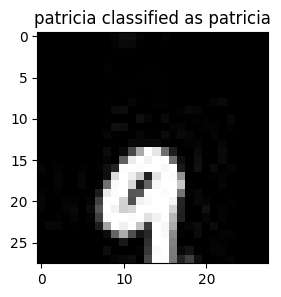

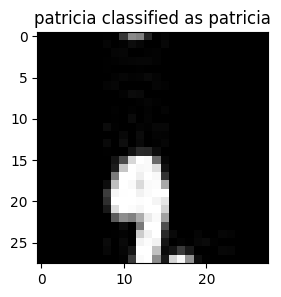

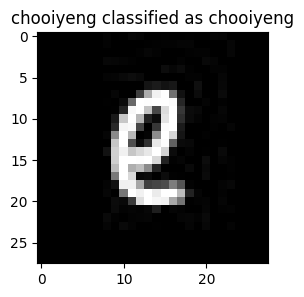

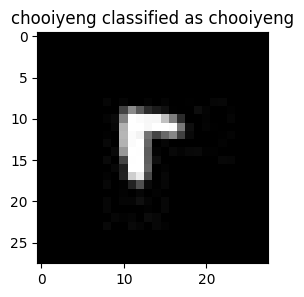

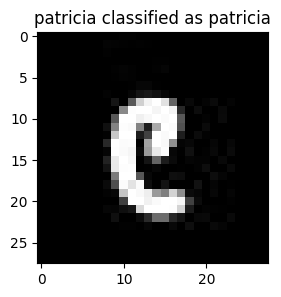

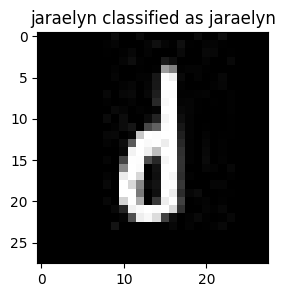

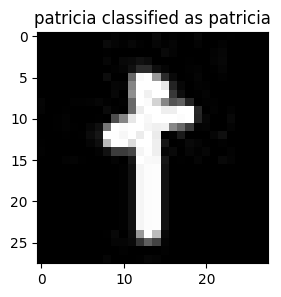

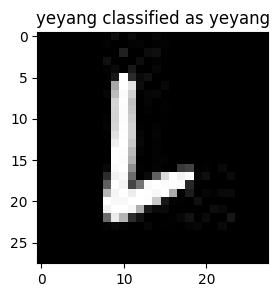

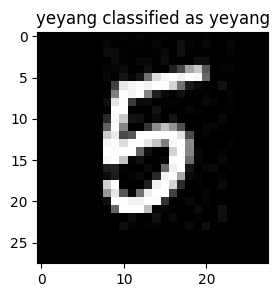

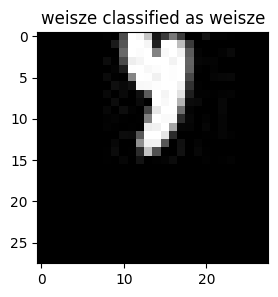

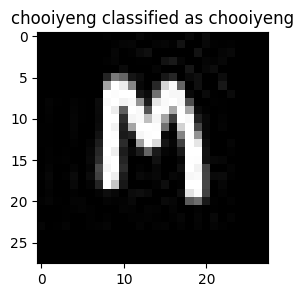

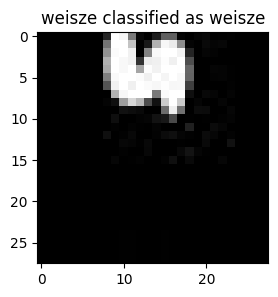

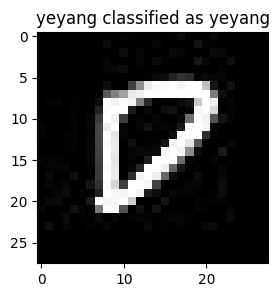

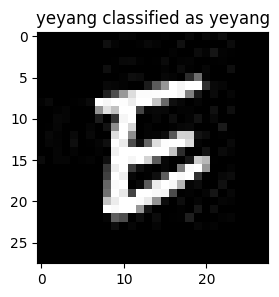

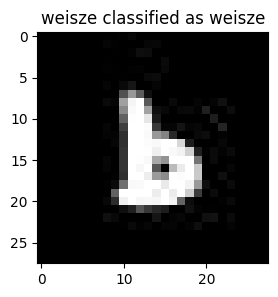

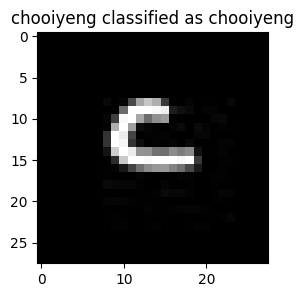

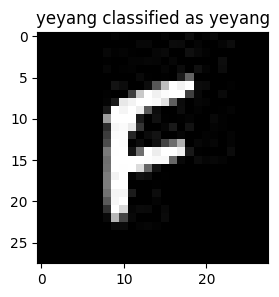

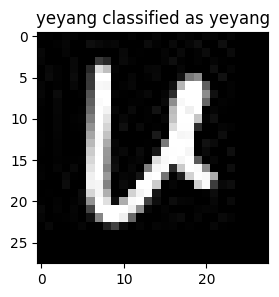

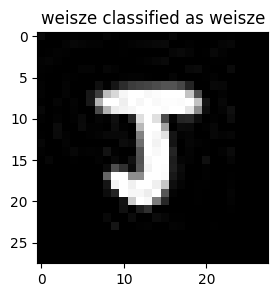

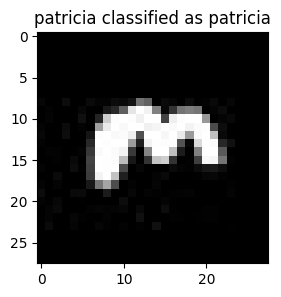

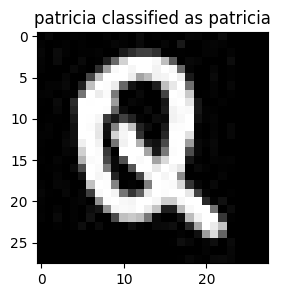

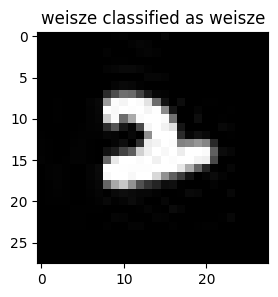

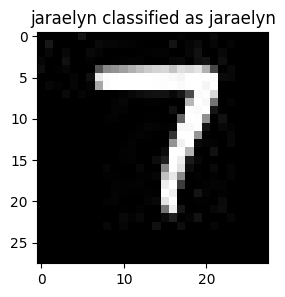

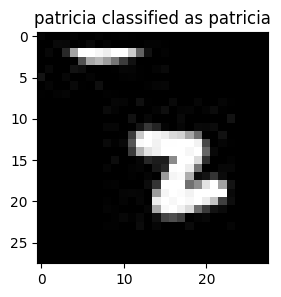

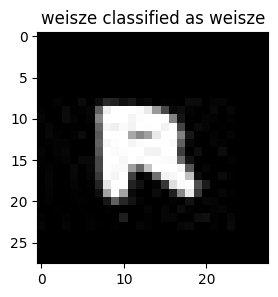

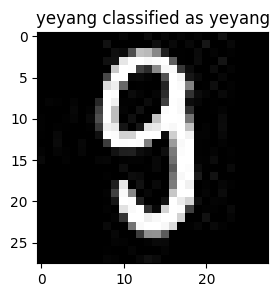

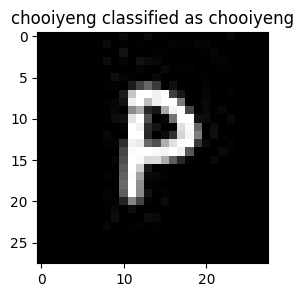

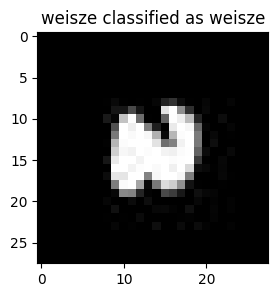

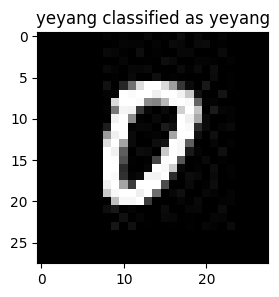

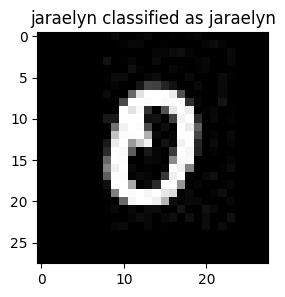

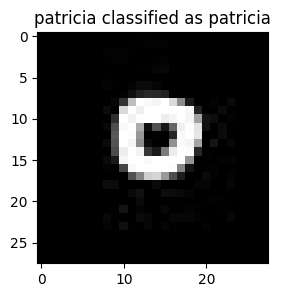

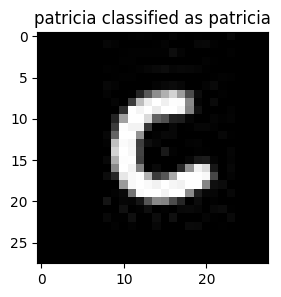

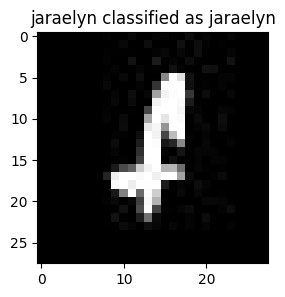

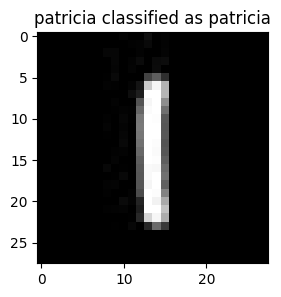

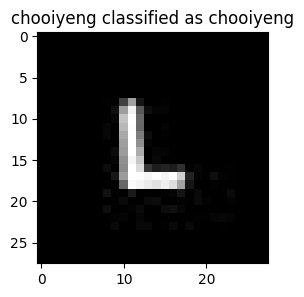

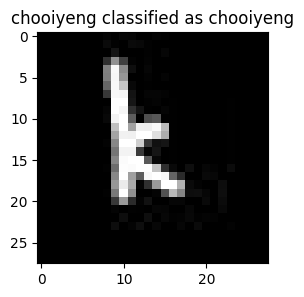

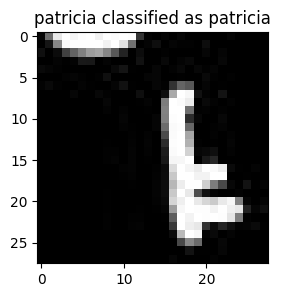

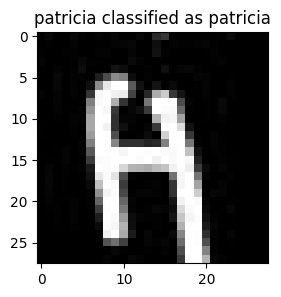

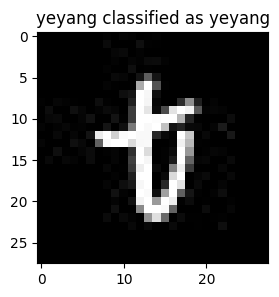

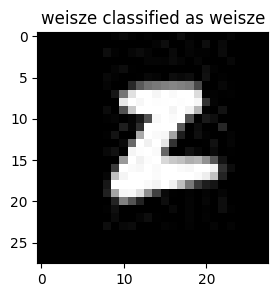

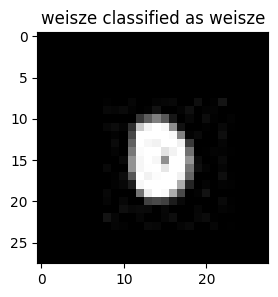

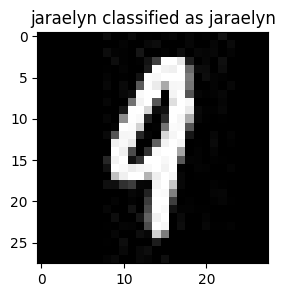

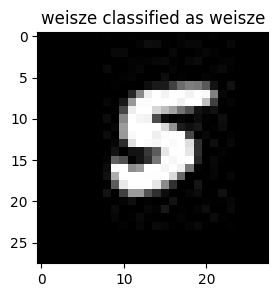

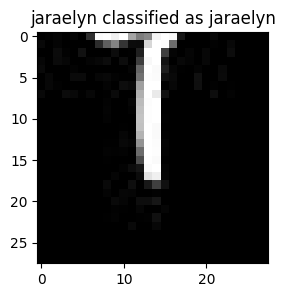

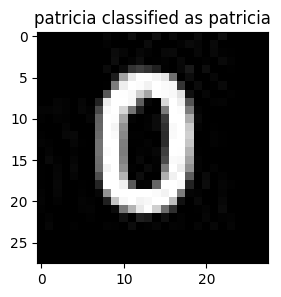

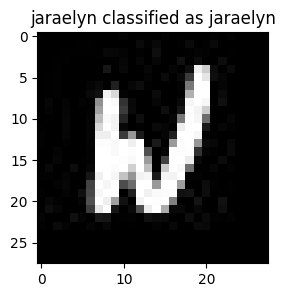

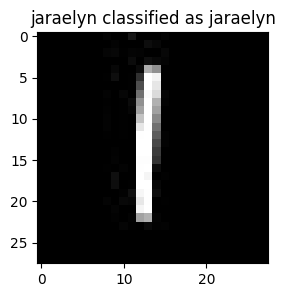

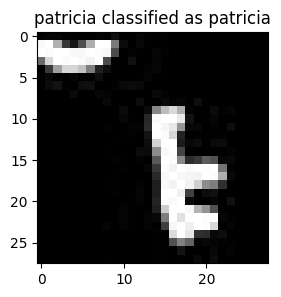

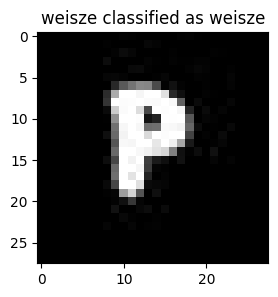

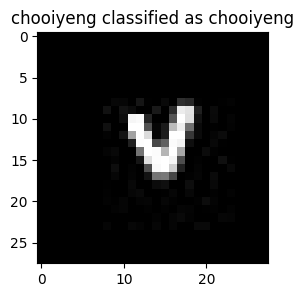

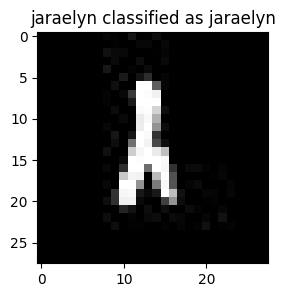

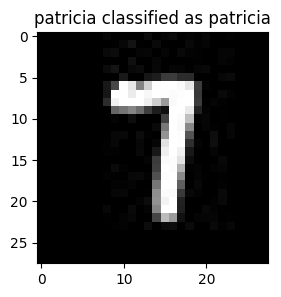

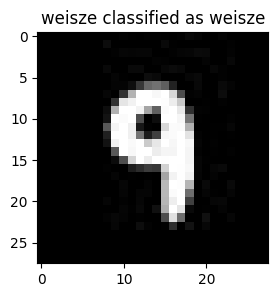

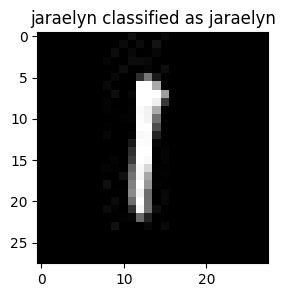

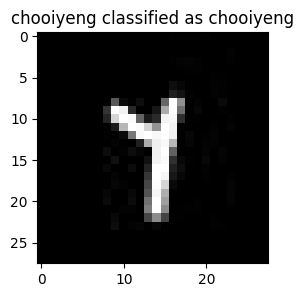

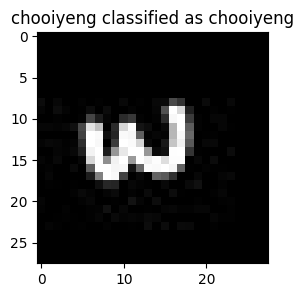

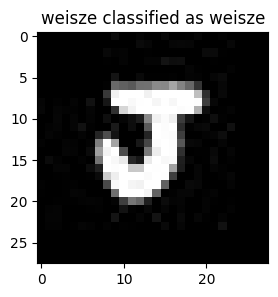

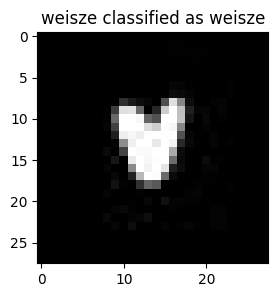

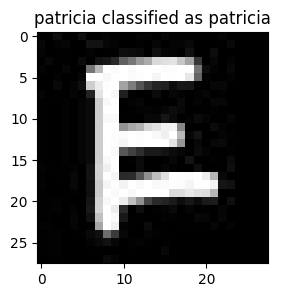

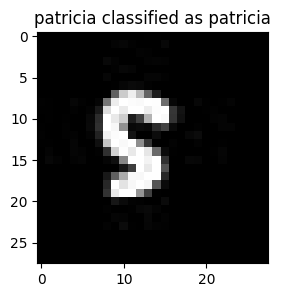

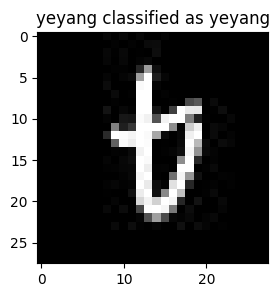

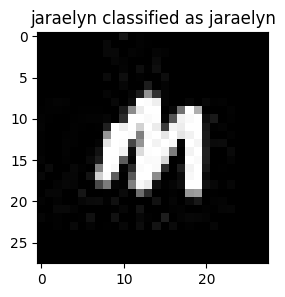

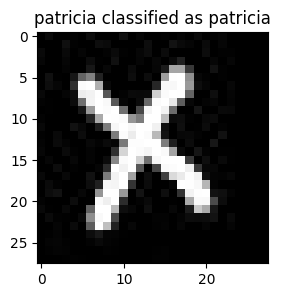

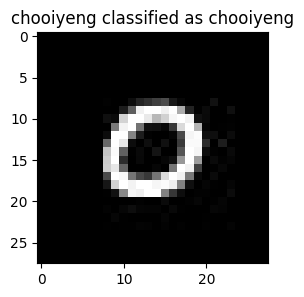

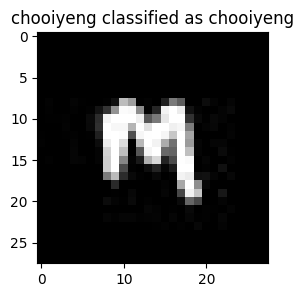

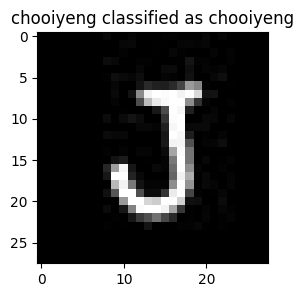

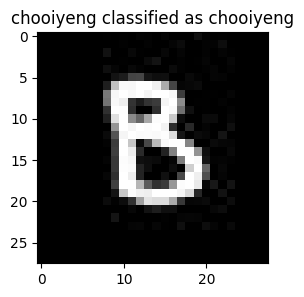

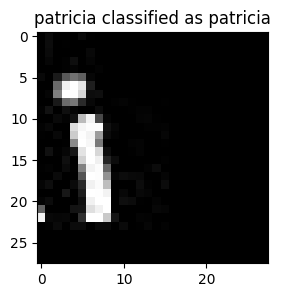

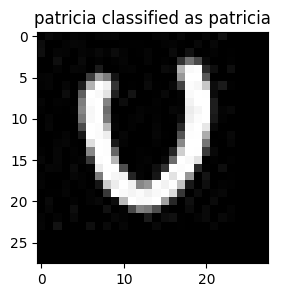

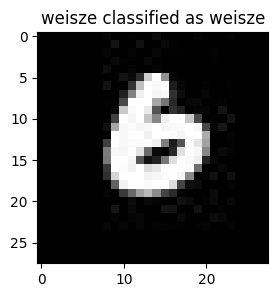

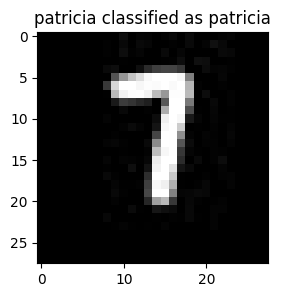

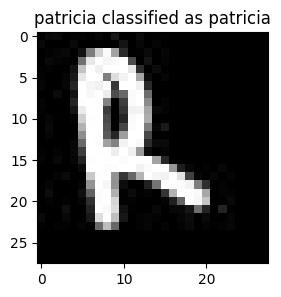

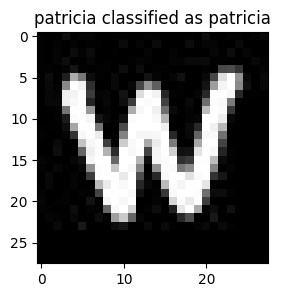

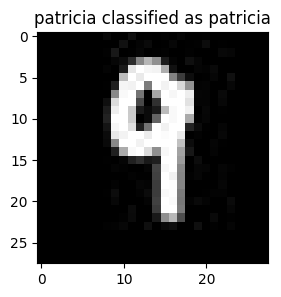

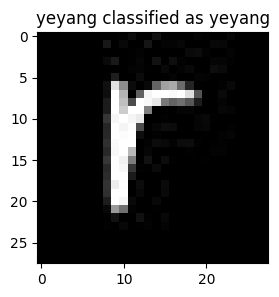

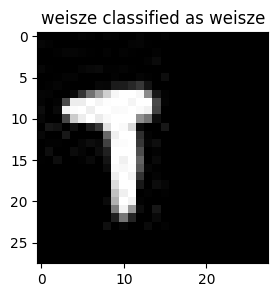

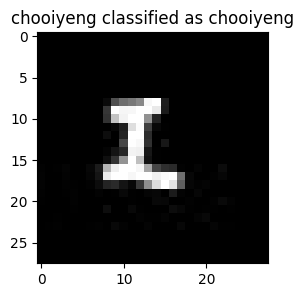

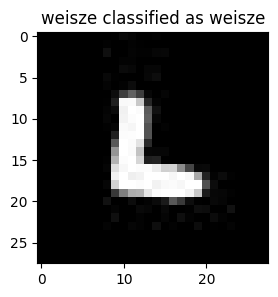

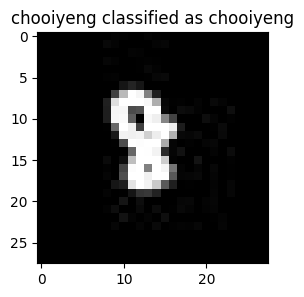

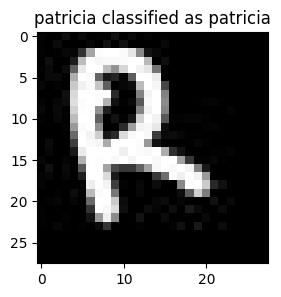

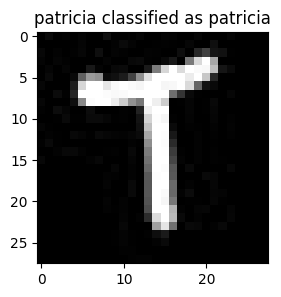

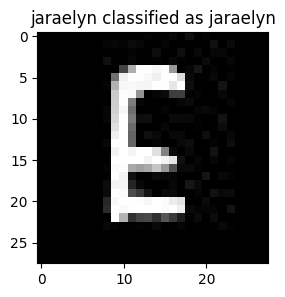

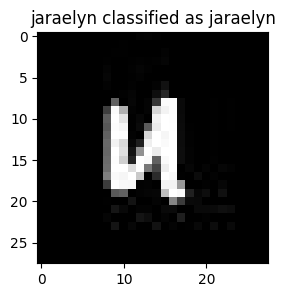

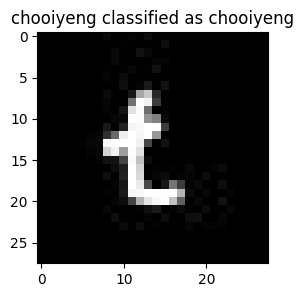

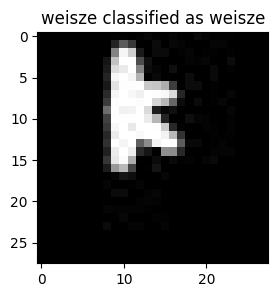

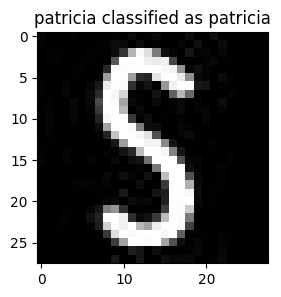

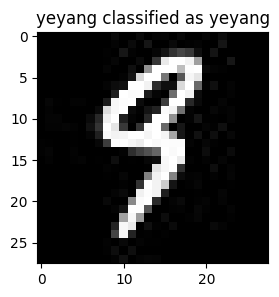

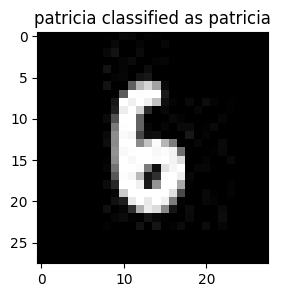

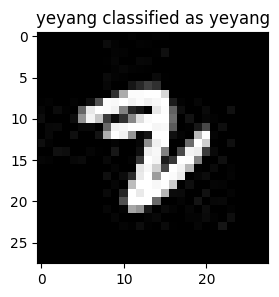

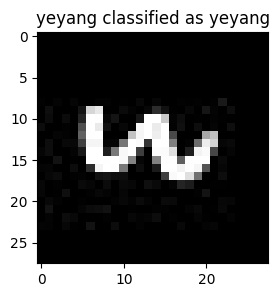

In [ ]:
classified_report(model, device, test_loader)